In [4]:
"""
Sistema de Clasificación Jerárquica - Entrenamiento de Modelos
=============================================================

Este notebook implementa un sistema de clasificación jerárquica con 4 modelos:

1. MODELO PRINCIPAL: Clasificador de Categorías (Derecho, Sociología, Técnico)
2. MODELO DERECHO: Clasificador de Temas dentro de la categoría Derecho
3. MODELO SOCIOLOGÍA: Clasificador de Temas dentro de la categoría Sociología  
4. MODELO TÉCNICO: Clasificador de Temas dentro de la categoría Técnico

Arquitectura:
Pregunta → [Modelo Principal] → Categoría → [Modelo Específico] → Tema

Objetivos:
- Entrenar 4 modelos especializados
- Evaluar rendimiento individual y del sistema completo
- Implementar pipeline de predicción jerárquica
- Optimizar hiperparámetros para cada modelo
- Crear visualizaciones del sistema jerárquico
"""

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
import warnings
from collections import defaultdict

warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")


def convert_string_to_array(vector_string):
    """Convierte string de vector a numpy array"""
    try:
        if vector_string is None or vector_string == '' or pd.isna(vector_string):
            return np.array([0])

        vector_string = str(vector_string).strip('[]')
        if not vector_string.strip():
            return np.array([0])

        vector_list = [float(x.strip()) for x in vector_string.split(',') if x.strip()]
        if not vector_list:
            return np.array([0])

        return np.array(vector_list)
    except Exception as e:
        try:
            return np.array(ast.literal_eval(vector_string))
        except:
            print(f"Warning: Could not parse vector '{vector_string}', using [0]")
            return np.array([0])


def pad_vector(vector, target_length):
    """Rellena vector con ceros hasta longitud objetivo"""
    if len(vector) < target_length:
        return np.pad(vector, (0, target_length - len(vector)), mode='constant')
    return vector


def evaluate_model_detailed(model, X_train, X_test, y_train, y_test, model_name, class_names):
    """Evalúa un modelo y retorna métricas detalladas"""

    # Entrenar
    model.fit(X_train, y_train)

    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Métricas
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    # Reporte de clasificación
    report = classification_report(y_test, y_pred_test, target_names=class_names, output_dict=True)

    results = {
        'model': model,
        'model_name': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'y_pred_test': y_pred_test,
        'classification_report': report
    }

    print(f"\n🤖 {model_name}")
    print(f"  Accuracy Entrenamiento: {train_acc:.4f}")
    print(f"  Accuracy Prueba: {test_acc:.4f}")
    print(f"  F1-Score Entrenamiento: {train_f1:.4f}")
    print(f"  F1-Score Prueba: {test_f1:.4f}")

    return results



# 1. Carga y Preparación de Datos


In [6]:
from utils.repository.repository import Repository

repo = Repository()

# Cargar datos
if not os.path.exists('data/augmented_questions_vector_category_chapter.csv'):
    print("Obteniendo preguntas del repositorio...")
    questions = repo.fetch_questions(limit=-1, min_number=1, max_number=45, is_vector=True)

    os.makedirs('data', exist_ok=True)
    df = pd.DataFrame([question.get_vector_category() for question in questions])
    df.to_csv('data/augmented_questions_vector_category_chapter.csv', index=False)
else:
    print("Cargando datos desde CSV...")
    df = pd.read_csv('data/augmented_questions_vector_category_chapter.csv').dropna()

# Limpiar datos
bad_data = df[
    ((df['chapter'] < 27) & (df['category'] != 1)) |
    (((df['chapter'] > 27) & (df['chapter'] < 38)) & (df['category'] != 2)) |
    ((df['chapter'] >= 38) & (df['category'] != 3))
]

print(f"Recategorizando {len(bad_data)} registros inconsistentes")

def recategorize(row):
    if row['chapter'] < 27:
        return 1
    elif 27 <= row['chapter'] < 38:
        return 2
    else:
        return 3

df['category'] = df.apply(recategorize, axis=1)

# save cleaned data
df.to_csv('data/augmented_questions_vector_category_chapter.csv', index=False)



print(f"Dataset cargado: {len(df)} preguntas")
print(f"Categorías únicas: {df['category'].unique()}")
print(f"Rango de temas: {df['chapter'].min()} - {df['chapter'].max()}")


Repository initialized with Supabase client.
Cargando datos desde CSV...
Recategorizando 0 registros inconsistentes
Dataset cargado: 20072 preguntas
Categorías únicas: [1 2 3]
Rango de temas: 1 - 45


In [3]:
# Análisis inicial de distribución
print("\n" + "=" * 60)
print("ANÁLISIS INICIAL DE DISTRIBUCIÓN")
print("=" * 60)

# Distribución por categorías
print("\nDistribución por categorías:")
category_counts = df['category'].value_counts()
for category, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} preguntas ({percentage:.1f}%)")

# Distribución de temas por categoría
print("\nDistribución de temas por categoría:")
for category in df['category'].unique():
    category_data = df[df['category'] == category]
    unique_themes = category_data['chapter'].nunique()
    theme_range = f"{category_data['chapter'].min()}-{category_data['chapter'].max()}"
    print(f"  {category}: {unique_themes} temas únicos (rango: {theme_range})")



ANÁLISIS INICIAL DE DISTRIBUCIÓN

Distribución por categorías:
  1: 14316 preguntas (71.3%)
  2: 2915 preguntas (14.5%)
  3: 2841 preguntas (14.2%)

Distribución de temas por categoría:
  1: 26 temas únicos (rango: 1-26)
  2: 11 temas únicos (rango: 27-37)
  3: 8 temas únicos (rango: 38-45)


# 2. Procesamiento de Embeddings


In [9]:
print("\n" + "=" * 60)
print("PROCESAMIENTO DE EMBEDDINGS")
print("=" * 60)

# Procesar vectores
print("Procesando vectores embeddings...")
vectors = [convert_string_to_array(vec) for vec in df['vector']]

# Estadísticas
vector_lengths = [len(vec) for vec in vectors]
max_length = max(vector_lengths)
print(f"Longitud máxima de vectores: {max_length}")
print(f"Longitud promedio: {np.mean(vector_lengths):.2f}")

# Padear vectores
padded_vectors = [pad_vector(vec, max_length) for vec in vectors]
X_original = np.array(padded_vectors)
print(f"Forma de matriz original: {X_original.shape}")

# Aplicar PCA para reducción de dimensionalidad
print("\nAplicando PCA...")
pca = PCA(n_components=0.95, random_state=42)  # 95% de varianza
X_pca = pca.fit_transform(X_original)

print(f"Componentes PCA necesarios: {pca.n_components_}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Forma después de PCA: {X_pca.shape}")

# Guardar PCA para uso posterior
os.makedirs('models_hierarchical', exist_ok=True)
with open('models_hierarchical/pca_transformer.pkl', 'wb') as f:
    pickle.dump(pca, f)



PROCESAMIENTO DE EMBEDDINGS
Procesando vectores embeddings...
Longitud máxima de vectores: 3072
Longitud promedio: 3071.23
Forma de matriz original: (20072, 3072)

Aplicando PCA...
Componentes PCA necesarios: 1051
Varianza explicada: 0.9501
Forma después de PCA: (20072, 1051)


# 3. Preparación de Datos para Clasificación Jerárquica


In [10]:
print("\n" + "=" * 60)
print("PREPARACIÓN DE DATOS JERÁRQUICOS")
print("=" * 60)

# Codificar categorías
le_categories = LabelEncoder()
df['category_encoded'] = le_categories.fit_transform(df['category'])
category_mapping = dict(zip(le_categories.classes_, le_categories.transform(le_categories.classes_)))

print("Mapeo de categorías:")
for category, code in category_mapping.items():
    print(f"  {category}: {code}")

# Preparar datos por categoría para clasificación de temas
category_data = {}
theme_encoders = {}

for category in df['category'].unique():
    print(f"\nPreparando datos para categoría: {category}")

    # Filtrar datos de esta categoría
    mask = df['category'] == category
    category_df = df[mask].copy()
    category_X = X_pca[mask]

    # Codificar temas para esta categoría
    le_themes = LabelEncoder()
    category_df['chapter_encoded'] = le_themes.fit_transform(category_df['chapter'])

    # Almacenar información
    category_data[category] = {
        'df': category_df,
        'X': category_X,
        'y': category_df['chapter_encoded'].values,
        'n_samples': len(category_df),
        'n_themes': len(le_themes.classes_),
        'theme_mapping': dict(zip(le_themes.classes_, le_themes.transform(le_themes.classes_)))
    }

    theme_encoders[category] = le_themes

    print(f"  Muestras: {category_data[category]['n_samples']}")
    print(f"  Temas únicos: {category_data[category]['n_themes']}")
    print(f"  Rango de temas: {min(le_themes.classes_)} - {max(le_themes.classes_)}")

# Guardar encoders
with open('models_hierarchical/category_encoder.pkl', 'wb') as f:
    pickle.dump(le_categories, f)

with open('models_hierarchical/theme_encoders.pkl', 'wb') as f:
    pickle.dump(theme_encoders, f)



PREPARACIÓN DE DATOS JERÁRQUICOS
Mapeo de categorías:
  1: 0
  2: 1
  3: 2

Preparando datos para categoría: 1
  Muestras: 14316
  Temas únicos: 26
  Rango de temas: 1 - 26

Preparando datos para categoría: 2
  Muestras: 2915
  Temas únicos: 11
  Rango de temas: 27 - 37

Preparando datos para categoría: 3
  Muestras: 2841
  Temas únicos: 8
  Rango de temas: 38 - 45


# 4. División de Datos


In [11]:
print("\n" + "=" * 60)
print("DIVISIÓN DE DATOS")
print("=" * 60)

# División para modelo principal (categorías)
X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(
    X_pca, df['category_encoded'], test_size=0.2, random_state=42, stratify=df['category_encoded']
)

print("Modelo Principal (Categorías):")
print(f"  Entrenamiento: {len(X_main_train)} muestras")
print(f"  Prueba: {len(X_main_test)} muestras")

# División para modelos de temas por categoría
category_splits = {}

for category in df['category'].unique():
    cat_data = category_data[category]

    # Solo dividir si hay suficientes muestras
    if cat_data['n_samples'] >= 10:  # Mínimo 10 muestras
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                cat_data['X'], cat_data['y'],
                test_size=0.2, random_state=42,
                stratify=cat_data['y'] if cat_data['n_themes'] > 1 else None
            )

            category_splits[category] = {
                'X_train': X_train, 'X_test': X_test,
                'y_train': y_train, 'y_test': y_test
            }

            print(f"\n{category}:")
            print(f"  Entrenamiento: {len(X_train)} muestras")
            print(f"  Prueba: {len(X_test)} muestras")
            print(f"  Temas en entrenamiento: {len(np.unique(y_train))}")
            print(f"  Temas en prueba: {len(np.unique(y_test))}")

        except ValueError as e:
            print(f"\n{category}: No se puede dividir (pocas muestras o un solo tema)")
            category_splits[category] = None
    else:
        print(f"\n{category}: Insuficientes muestras ({cat_data['n_samples']})")
        category_splits[category] = None



DIVISIÓN DE DATOS
Modelo Principal (Categorías):
  Entrenamiento: 16057 muestras
  Prueba: 4015 muestras

1:
  Entrenamiento: 11452 muestras
  Prueba: 2864 muestras
  Temas en entrenamiento: 26
  Temas en prueba: 26

2:
  Entrenamiento: 2332 muestras
  Prueba: 583 muestras
  Temas en entrenamiento: 11
  Temas en prueba: 11

3:
  Entrenamiento: 2272 muestras
  Prueba: 569 muestras
  Temas en entrenamiento: 8
  Temas en prueba: 8


# 5. Entrenamiento del Modelo Principal (Clasificador de Categorías)



ENTRENAMIENTO CON VALIDACIÓN CRUZADA Y ANÁLISIS DE DESBALANCEO

📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES
  Categoría  Cantidad  Porcentaje
Categoría_1     14316   71.323236
Categoría_2      2915   14.522718
Categoría_3      2841   14.154045


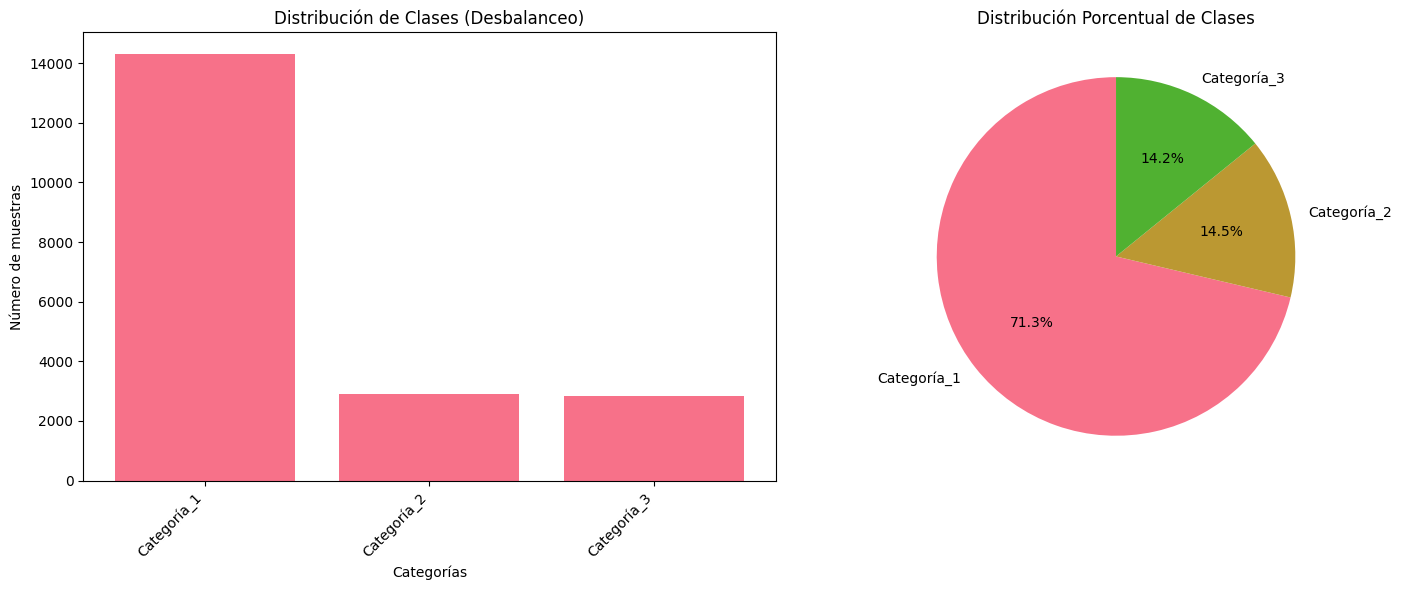


🔄 EJECUTANDO VALIDACIÓN CRUZADA...

📊 Evaluando Logistic Regression...
  F1-Weighted: 0.9708 (±0.0010)
  F1-Macro:    0.9559 (±0.0018)
  Accuracy:    0.9705 (±0.0010)

📊 Evaluando Random Forest...
  F1-Weighted: 0.9080 (±0.0042)
  F1-Macro:    0.8615 (±0.0065)
  Accuracy:    0.9133 (±0.0037)

📊 Evaluando SVM...
  F1-Weighted: 0.9869 (±0.0017)
  F1-Macro:    0.9799 (±0.0024)
  Accuracy:    0.9869 (±0.0017)

📊 Evaluando MLP...
  F1-Weighted: 0.9845 (±0.0018)
  F1-Macro:    0.9760 (±0.0036)
  Accuracy:    0.9846 (±0.0018)

📈 GENERANDO VISUALIZACIONES...


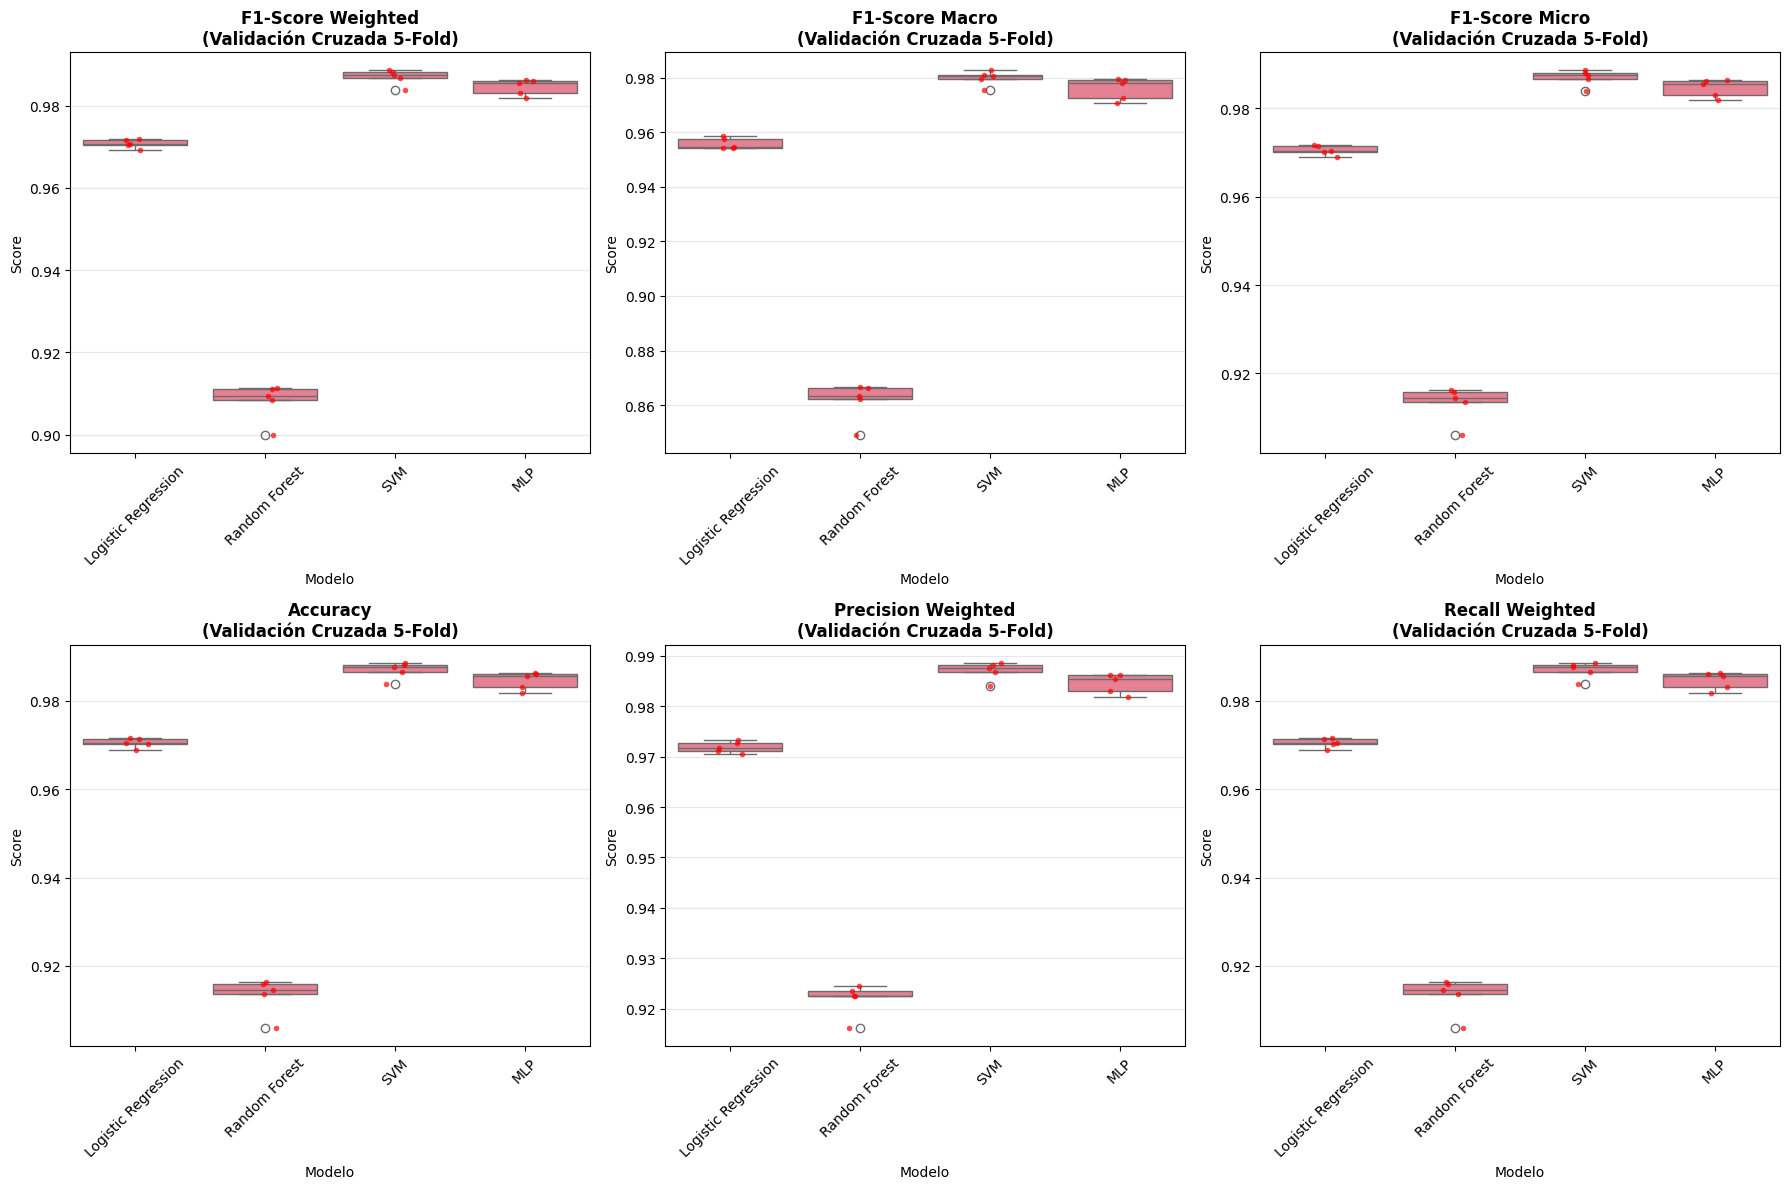


🏆 MEJOR MODELO: SVM
F1-Weighted: 0.9869 (±0.0017)
F1-Macro:    0.9799 (±0.0024)
Accuracy:    0.9869 (±0.0017)

🔍 MATRIZ DE CONFUSIÓN - SVM
Matriz de Confusión (números absolutos):
                   Pred: Categoría_1  Pred: Categoría_2  Pred: Categoría_3
Real: Categoría_1               2824                 24                 16
Real: Categoría_2                  5                578                  0
Real: Categoría_3                 14                  1                553


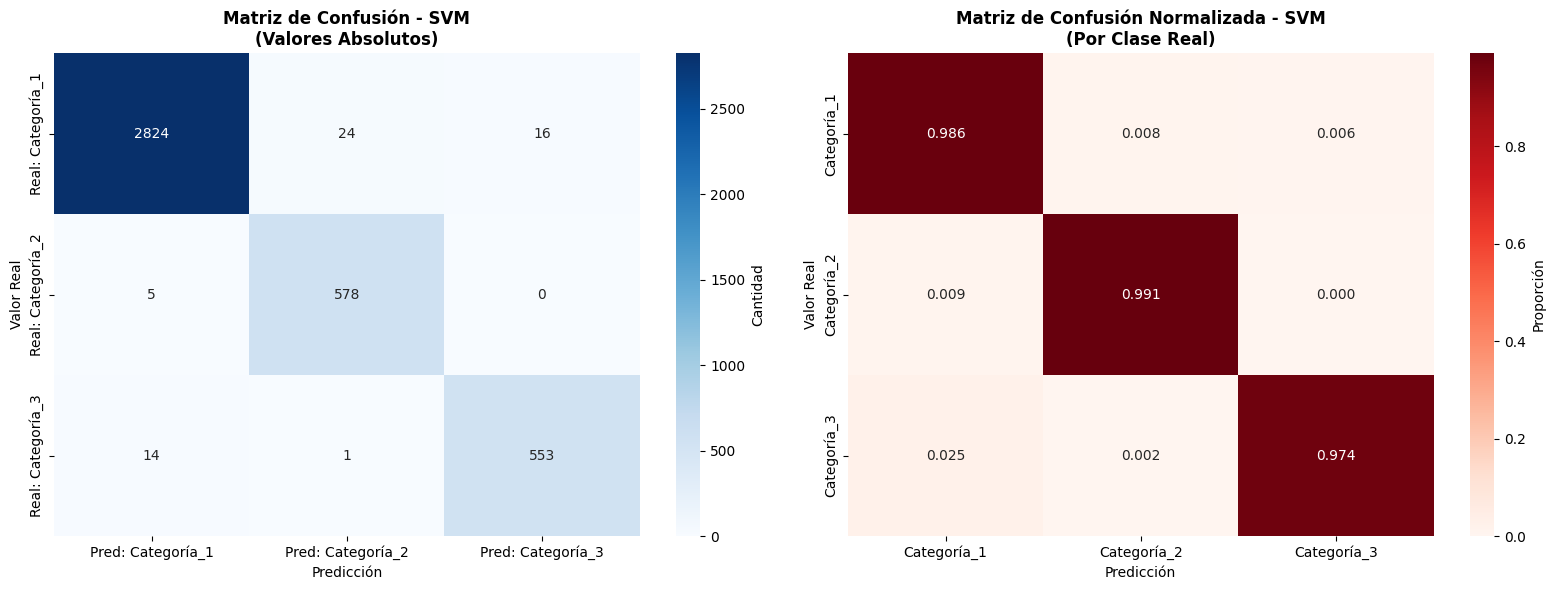


📋 REPORTE DETALLADO POR CLASE
Métricas generales:
  - Accuracy: 0.9851
  - F1-Score Weighted: 0.9851
  - F1-Score Macro: 0.9790

Reporte de clasificación detallado:
              precision    recall  f1-score   support

 Categoría_1     0.9933    0.9860    0.9897      2864
 Categoría_2     0.9585    0.9914    0.9747       583
 Categoría_3     0.9719    0.9736    0.9727       568

    accuracy                         0.9851      4015
   macro avg     0.9746    0.9837    0.9790      4015
weighted avg     0.9852    0.9851    0.9851      4015


📊 RESUMEN COMPARATIVO - VALIDACIÓN CRUZADA
Modelo             F1-Weighted     F1-Macro        Accuracy        Precision      
--------------------------------------------------------------------------------
   Logistic Regression 0.9708±0.001  0.9559±0.002  0.9705±0.001  0.9719±0.001
   Random Forest   0.9080±0.004  0.8615±0.006  0.9133±0.004  0.9219±0.003
🏆 SVM             0.9869±0.002  0.9799±0.002  0.9869±0.002  0.9870±0.002
   MLP             0

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("\n" + "=" * 60)
print("ENTRENAMIENTO CON VALIDACIÓN CRUZADA Y ANÁLISIS DE DESBALANCEO")
print("=" * 60)

# Configurar estilo para gráficos
plt.style.use('default')
sns.set_palette("husl")

# Definir modelos a probar (ajustados para desbalanceo)
models_to_test = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42, probability=True),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
}

# Combinar datos para análisis completo
X_full = np.vstack([X_main_train, X_main_test])
y_full = np.hstack([y_main_train, y_main_test])
category_names = [f"Categoría_{int(cls)}" for cls in le_categories.classes_]

# ====================================================================
# 1. ANÁLISIS DEL DESBALANCEO
# ====================================================================
print("\n📊 ANÁLISIS DE DISTRIBUCIÓN DE CLASES")
print("=" * 50)

class_counts = Counter(y_full)
class_distribution = pd.DataFrame([
    (category_names[class_idx], count, count/len(y_full)*100)
    for class_idx, count in class_counts.items()
], columns=['Categoría', 'Cantidad', 'Porcentaje'])

class_distribution = class_distribution.sort_values('Cantidad', ascending=False)
print(class_distribution.to_string(index=False))

# Visualizar distribución de clases
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
ax1.bar(range(len(class_distribution)), class_distribution['Cantidad'])
ax1.set_xlabel('Categorías')
ax1.set_ylabel('Número de muestras')
ax1.set_title('Distribución de Clases (Desbalanceo)')
ax1.set_xticks(range(len(class_distribution)))
ax1.set_xticklabels(class_distribution['Categoría'], rotation=45, ha='right')

# Gráfico circular
ax2.pie(class_distribution['Cantidad'], labels=class_distribution['Categoría'],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribución Porcentual de Clases')

plt.tight_layout()
plt.show()

# ====================================================================
# 2. VALIDACIÓN CRUZADA CON MÚLTIPLES MÉTRICAS
# ====================================================================
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir múltiples métricas (importantes para clases desbalanceadas)
scoring_metrics = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

print("\n🔄 EJECUTANDO VALIDACIÓN CRUZADA...")
print("=" * 50)

cv_results = {}
all_scores_df = []

for model_name, model in models_to_test.items():
    print(f"\n📊 Evaluando {model_name}...")

    # Validación cruzada con múltiples métricas
    scores = cross_validate(model, X_full, y_full, cv=cv_folds,
                           scoring=scoring_metrics, n_jobs=-1, return_train_score=False)

    # Organizar resultados
    model_results = {}
    for metric_name in scoring_metrics.keys():
        test_scores = scores[f'test_{metric_name}']
        model_results[metric_name] = {
            'scores': test_scores,
            'mean': test_scores.mean(),
            'std': test_scores.std()
        }

        # Para el DataFrame de visualización
        for fold_idx, score in enumerate(test_scores):
            all_scores_df.append({
                'Modelo': model_name,
                'Métrica': metric_name,
                'Fold': fold_idx + 1,
                'Score': score
            })

    cv_results[model_name] = model_results

    # Mostrar resultados principales
    print(f"  F1-Weighted: {model_results['f1_weighted']['mean']:.4f} (±{model_results['f1_weighted']['std']:.4f})")
    print(f"  F1-Macro:    {model_results['f1_macro']['mean']:.4f} (±{model_results['f1_macro']['std']:.4f})")
    print(f"  Accuracy:    {model_results['accuracy']['mean']:.4f} (±{model_results['accuracy']['std']:.4f})")

# ====================================================================
# 3. VISUALIZACIÓN CON BOXPLOTS
# ====================================================================
print("\n📈 GENERANDO VISUALIZACIONES...")

scores_df = pd.DataFrame(all_scores_df)

# Crear subplots para diferentes métricas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

metrics_to_plot = ['f1_weighted', 'f1_macro', 'f1_micro', 'accuracy', 'precision_weighted', 'recall_weighted']
metric_titles = ['F1-Score Weighted', 'F1-Score Macro', 'F1-Score Micro',
                'Accuracy', 'Precision Weighted', 'Recall Weighted']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    metric_data = scores_df[scores_df['Métrica'] == metric]

    sns.boxplot(data=metric_data, x='Modelo', y='Score', ax=axes[idx])
    axes[idx].set_title(f'{title}\n(Validación Cruzada 5-Fold)', fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

    # Agregar puntos individuales
    sns.stripplot(data=metric_data, x='Modelo', y='Score', ax=axes[idx],
                 color='red', alpha=0.7, size=4)

plt.tight_layout()
plt.show()

# ====================================================================
# 4. SELECCIÓN DEL MEJOR MODELO Y ENTRENAMIENTO FINAL
# ====================================================================
# Seleccionar mejor modelo basado en F1-weighted (mejor para desbalanceo)
best_model_name = max(cv_results.keys(),
                     key=lambda x: cv_results[x]['f1_weighted']['mean'])

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print("=" * 50)
best_results = cv_results[best_model_name]
print(f"F1-Weighted: {best_results['f1_weighted']['mean']:.4f} (±{best_results['f1_weighted']['std']:.4f})")
print(f"F1-Macro:    {best_results['f1_macro']['mean']:.4f} (±{best_results['f1_macro']['std']:.4f})")
print(f"Accuracy:    {best_results['accuracy']['mean']:.4f} (±{best_results['accuracy']['std']:.4f})")

# Entrenar modelo final
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

final_model = models_to_test[best_model_name]
final_model.fit(X_final_train, y_final_train)
final_predictions = final_model.predict(X_final_test)

# ====================================================================
# 5. MATRICES DE CONFUSIÓN (TABLAS DE CONTINGENCIA)
# ====================================================================
print(f"\n🔍 MATRIZ DE CONFUSIÓN - {best_model_name}")
print("=" * 50)

# Calcular matriz de confusión
cm = confusion_matrix(y_final_test, final_predictions)

# Crear DataFrame para mejor visualización
cm_df = pd.DataFrame(cm,
                    index=[f'Real: {cat}' for cat in category_names],
                    columns=[f'Pred: {cat}' for cat in category_names])

print("Matriz de Confusión (números absolutos):")
print(cm_df)

# Matriz de confusión normalizada
cm_normalized = confusion_matrix(y_final_test, final_predictions, normalize='true')
cm_norm_df = pd.DataFrame(cm_normalized,
                         index=category_names,
                         columns=category_names)

# Visualizar matrices de confusión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Matriz absoluta
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Cantidad'})
ax1.set_title(f'Matriz de Confusión - {best_model_name}\n(Valores Absolutos)', fontweight='bold')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Valor Real')

# Matriz normalizada
sns.heatmap(cm_norm_df, annot=True, fmt='.3f', cmap='Reds', ax=ax2, cbar_kws={'label': 'Proporción'})
ax2.set_title(f'Matriz de Confusión Normalizada - {best_model_name}\n(Por Clase Real)', fontweight='bold')
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')

plt.tight_layout()
plt.show()

# ====================================================================
# 6. REPORTE DETALLADO POR CLASE
# ====================================================================
print(f"\n📋 REPORTE DETALLADO POR CLASE")
print("=" * 50)

final_f1_weighted = f1_score(y_final_test, final_predictions, average='weighted')
final_f1_macro = f1_score(y_final_test, final_predictions, average='macro')
final_accuracy = accuracy_score(y_final_test, final_predictions)

print(f"Métricas generales:")
print(f"  - Accuracy: {final_accuracy:.4f}")
print(f"  - F1-Score Weighted: {final_f1_weighted:.4f}")
print(f"  - F1-Score Macro: {final_f1_macro:.4f}")

print(f"\nReporte de clasificación detallado:")
print(classification_report(y_final_test, final_predictions,
                          target_names=category_names, digits=4))

# ====================================================================
# 7. RESUMEN COMPARATIVO DE TODOS LOS MODELOS
# ====================================================================
print(f"\n📊 RESUMEN COMPARATIVO - VALIDACIÓN CRUZADA")
print("=" * 80)
print(f"{'Modelo':<18} {'F1-Weighted':<15} {'F1-Macro':<15} {'Accuracy':<15} {'Precision':<15}")
print("-" * 80)

for model_name, results in cv_results.items():
    marker = "🏆 " if model_name == best_model_name else "   "
    print(f"{marker}{model_name:<15} "
          f"{results['f1_weighted']['mean']:.4f}±{results['f1_weighted']['std']:.3f}  "
          f"{results['f1_macro']['mean']:.4f}±{results['f1_macro']['std']:.3f}  "
          f"{results['accuracy']['mean']:.4f}±{results['accuracy']['std']:.3f}  "
          f"{results['precision_weighted']['mean']:.4f}±{results['precision_weighted']['std']:.3f}")

# Guardar modelo
import os
os.makedirs('models_hierarchical', exist_ok=True)

with open('models_hierarchical/main_category_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print(f"\n✅ Modelo {best_model_name} guardado exitosamente en 'models_hierarchical/'")
print(f"\n💡 Recomendaciones para el desbalanceo:")
print("   - Se usaron pesos balanceados en todos los modelos")
print("   - F1-Score Weighted es más apropiado que Accuracy para datos desbalanceados")
print("   - Considera técnicas de remuestreo (SMOTE, ADASYN) si el rendimiento no es satisfactorio")
print("   - Las clases minoritarias pueden necesitar más datos o features específicas")

# 6. Entrenamiento de Modelos de Temas por Categoría


In [8]:
print("\n" + "=" * 60)
print("ENTRENAMIENTO DE MODELOS DE TEMAS CON VALIDACIÓN CRUZADA")
print("=" * 60)

# Definir modelos optimizados para temas
def get_theme_models():
    return {
        'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42),
        'SVM': SVC(class_weight='balanced', random_state=42, probability=True),
        'MLP': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42, early_stopping=True)
    }

theme_model_results = {}

# Procesar categorías 1, 2, 3
categories = [1, 2, 3]
print(f"Procesando categorías: {categories}")

for category in categories:
    category_name = f"Categoría_{category}"
    print(f"\n{'=' * 50}")
    print(f"ENTRENANDO MODELOS PARA: {category_name}")
    print(f"{'=' * 50}")

    # Verificar si hay datos suficientes
    if category not in category_splits or category_splits[category] is None:
        print(f"❌ Saltando {category_name}: datos insuficientes o no disponibles")
        theme_model_results[category] = None
        continue

    # Obtener datos de esta categoría
    split_data = category_splits[category]
    X_train = split_data['X_train']
    X_test = split_data['X_test']
    y_train = split_data['y_train']
    y_test = split_data['y_test']

    # Obtener nombres de temas para esta categoría
    if category not in theme_encoders:
        print(f"❌ Saltando {category_name}: no hay encoder de temas")
        theme_model_results[category] = None
        continue

    theme_encoder = theme_encoders[category]
    theme_names = [f"Tema_{int(theme)}" for theme in theme_encoder.classes_]

    # Combinar datos para validación cruzada
    X_category_full = np.vstack([X_train, X_test])
    y_category_full = np.hstack([y_train, y_test])

    print(f"📊 Información de {category_name}:")
    print(f"   - Total de muestras: {len(X_category_full)}")
    print(f"   - Número de temas: {len(theme_names)}")
    print(f"   - Temas: {theme_names}")

    # Análisis de distribución de temas
    theme_counts = Counter(y_category_full)
    print(f"   - Distribución de temas:")
    for theme_idx, count in sorted(theme_counts.items()):
        theme_name = theme_names[theme_idx] if theme_idx < len(theme_names) else f"Tema_{theme_idx}"
        percentage = (count / len(y_category_full)) * 100
        print(f"     * {theme_name}: {count} ({percentage:.1f}%)")

    # Solo proceder si hay al menos 2 clases y datos suficientes
    if len(theme_names) < 2:
        print(f"⚠️  Saltando {category_name}: solo tiene {len(theme_names)} tema(s)")
        theme_model_results[category] = None
        continue

    if len(X_category_full) < 10:
        print(f"⚠️  Saltando {category_name}: muy pocas muestras ({len(X_category_full)})")
        theme_model_results[category] = None
        continue

    # Configurar validación cruzada adaptativa
    n_splits = min(5, len(X_category_full) // max(2, len(theme_names)))
    n_splits = max(2, n_splits)  # Mínimo 2 splits

    try:
        cv_folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        # Verificar que la división es posible
        list(cv_folds.split(X_category_full, y_category_full))
        print(f"   - Usando validación cruzada con {n_splits} folds")
        use_cv = True
    except ValueError as e:
        print(f"⚠️  Error en validación cruzada: {e}")
        print(f"   - Usando división train/test simple")
        use_cv = False

    # Entrenar modelos para esta categoría
    category_results = {}
    models_to_test = get_theme_models()

    print(f"\n🔄 Evaluando modelos para {category_name}...")

    for model_name, model in models_to_test.items():
        print(f"\n📊 Evaluando {model_name}...")

        try:
            if use_cv:
                # Validación cruzada
                scoring_metrics = {
                    'f1_weighted': make_scorer(f1_score, average='weighted'),
                    'f1_macro': make_scorer(f1_score, average='macro'),
                    'accuracy': 'accuracy'
                }

                scores = cross_validate(model, X_category_full, y_category_full,
                                      cv=cv_folds, scoring=scoring_metrics, n_jobs=-1)

                # Entrenar modelo final con todos los datos
                final_model = type(model)(**model.get_params())
                final_model.fit(X_category_full, y_category_full)

                # Guardar resultados
                category_results[model_name] = {
                    'model': final_model,
                    'cv_f1_weighted_mean': scores['test_f1_weighted'].mean(),
                    'cv_f1_weighted_std': scores['test_f1_weighted'].std(),
                    'cv_f1_macro_mean': scores['test_f1_macro'].mean(),
                    'cv_f1_macro_std': scores['test_f1_macro'].std(),
                    'cv_accuracy_mean': scores['test_accuracy'].mean(),
                    'cv_accuracy_std': scores['test_accuracy'].std(),
                    'test_f1': scores['test_f1_weighted'].mean()  # Para compatibilidad
                }

                print(f"  F1-Weighted: {scores['test_f1_weighted'].mean():.4f} (±{scores['test_f1_weighted'].std():.4f})")
                print(f"  F1-Macro:    {scores['test_f1_macro'].mean():.4f} (±{scores['test_f1_macro'].std():.4f})")
                print(f"  Accuracy:    {scores['test_accuracy'].mean():.4f} (±{scores['test_accuracy'].std():.4f})")

            else:
                # División simple train/test
                X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
                    X_category_full, y_category_full, test_size=0.3, random_state=42,
                    stratify=y_category_full if len(np.unique(y_category_full)) > 1 else None
                )

                # Entrenar modelo
                model.fit(X_train_split, y_train_split)
                predictions = model.predict(X_test_split)

                # Calcular métricas
                f1_weighted = f1_score(y_test_split, predictions, average='weighted')
                f1_macro = f1_score(y_test_split, predictions, average='macro')
                accuracy = accuracy_score(y_test_split, predictions)

                category_results[model_name] = {
                    'model': model,
                    'test_f1_weighted': f1_weighted,
                    'test_f1_macro': f1_macro,
                    'test_accuracy': accuracy,
                    'test_f1': f1_weighted  # Para compatibilidad
                }

                print(f"  F1-Weighted: {f1_weighted:.4f}")
                print(f"  F1-Macro:    {f1_macro:.4f}")
                print(f"  Accuracy:    {accuracy:.4f}")

        except Exception as e:
            print(f"❌ Error entrenando {model_name} para {category_name}: {e}")
            continue

    # Seleccionar mejor modelo para esta categoría
    if category_results:
        best_theme_model_name = max(category_results.keys(),
                                    key=lambda x: category_results[x]['test_f1'])
        best_theme_model = category_results[best_theme_model_name]['model']

        print(f"\n🏆 Mejor modelo para {category_name}: {best_theme_model_name}")
        if use_cv:
            result = category_results[best_theme_model_name]
            print(f"F1-Weighted: {result['cv_f1_weighted_mean']:.4f} (±{result['cv_f1_weighted_std']:.4f})")
        else:
            print(f"F1-Score: {category_results[best_theme_model_name]['test_f1']:.4f}")

        # Crear directorio si no existe
        import os
        os.makedirs('models_hierarchical', exist_ok=True)

        # Guardar mejor modelo para esta categoría
        model_filename = f'models_hierarchical/theme_model_categoria_{category}.pkl'
        with open(model_filename, 'wb') as f:
            pickle.dump(best_theme_model, f)

        # Guardar encoder de temas
        encoder_filename = f'models_hierarchical/theme_encoder_categoria_{category}.pkl'
        with open(encoder_filename, 'wb') as f:
            pickle.dump(theme_encoder, f)

        theme_model_results[category] = {
            'best_model_name': best_theme_model_name,
            'best_model': best_theme_model,
            'all_results': category_results,
            'n_themes': len(theme_names),
            'theme_names': theme_names,
            'theme_encoder': theme_encoder,
            'used_cv': use_cv
        }

        print(f"✅ Modelo guardado en: {model_filename}")
        print(f"✅ Encoder guardado en: {encoder_filename}")

    else:
        print(f"❌ No se pudieron entrenar modelos para {category_name}")
        theme_model_results[category] = None

# ====================================================================
# RESUMEN FINAL DE MODELOS DE TEMAS
# ====================================================================
print(f"\n{'=' * 60}")
print("RESUMEN DE MODELOS DE TEMAS")
print(f"{'=' * 60}")

successful_categories = [cat for cat in categories if theme_model_results.get(cat) is not None]
failed_categories = [cat for cat in categories if theme_model_results.get(cat) is None]

print(f"\n✅ Categorías procesadas exitosamente: {len(successful_categories)}")
for category in successful_categories:
    result = theme_model_results[category]
    print(f"   - Categoría_{category}: {result['best_model_name']} ({result['n_themes']} temas)")

if failed_categories:
    print(f"\n❌ Categorías no procesadas: {len(failed_categories)}")
    for category in failed_categories:
        print(f"   - Categoría_{category}")

print(f"\n📁 Modelos guardados en el directorio 'models_hierarchical/'")

# Mostrar estadísticas detalladas
print(f"\n📊 ESTADÍSTICAS DETALLADAS:")
print("-" * 50)
for category in successful_categories:
    result = theme_model_results[category]
    best_result = result['all_results'][result['best_model_name']]

    print(f"\nCategoría_{category} - {result['best_model_name']}:")
    print(f"  - Temas: {result['n_themes']}")
    if result['used_cv']:
        print(f"  - F1-Weighted: {best_result['cv_f1_weighted_mean']:.4f} (±{best_result['cv_f1_weighted_std']:.4f})")
        print(f"  - F1-Macro: {best_result['cv_f1_macro_mean']:.4f} (±{best_result['cv_f1_macro_std']:.4f})")
    else:
        print(f"  - F1-Weighted: {best_result['test_f1_weighted']:.4f}")
        print(f"  - F1-Macro: {best_result['test_f1_macro']:.4f}")


ENTRENAMIENTO DE MODELOS DE TEMAS CON VALIDACIÓN CRUZADA
Procesando categorías: [1, 2, 3]

ENTRENANDO MODELOS PARA: Categoría_1
📊 Información de Categoría_1:
   - Total de muestras: 14316
   - Número de temas: 26
   - Temas: ['Tema_1', 'Tema_2', 'Tema_3', 'Tema_4', 'Tema_5', 'Tema_6', 'Tema_7', 'Tema_8', 'Tema_9', 'Tema_10', 'Tema_11', 'Tema_12', 'Tema_13', 'Tema_14', 'Tema_15', 'Tema_16', 'Tema_17', 'Tema_18', 'Tema_19', 'Tema_20', 'Tema_21', 'Tema_22', 'Tema_23', 'Tema_24', 'Tema_25', 'Tema_26']
   - Distribución de temas:
     * Tema_1: 2202 (15.4%)
     * Tema_2: 450 (3.1%)
     * Tema_3: 195 (1.4%)
     * Tema_4: 274 (1.9%)
     * Tema_5: 559 (3.9%)
     * Tema_6: 398 (2.8%)
     * Tema_7: 234 (1.6%)
     * Tema_8: 524 (3.7%)
     * Tema_9: 474 (3.3%)
     * Tema_10: 593 (4.1%)
     * Tema_11: 270 (1.9%)
     * Tema_12: 386 (2.7%)
     * Tema_13: 276 (1.9%)
     * Tema_14: 277 (1.9%)
     * Tema_15: 302 (2.1%)
     * Tema_16: 2120 (14.8%)
     * Tema_17: 346 (2.4%)
     * Tema_18

# 7. Evaluación del Sistema Jerárquico Completo


In [25]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

print("\n" + "=" * 60)
print("EVALUACIÓN DEL SISTEMA JERÁRQUICO COMPLETO")
print("=" * 60)


class HierarchicalClassifier:
    """Clasificador jerárquico que combina modelo principal y modelos de temas"""

    def __init__(self, main_model, theme_models, category_encoder, theme_encoders):
        self.main_model = main_model
        self.theme_models = theme_models
        self.category_encoder = category_encoder
        self.theme_encoders = theme_encoders

    def predict(self, X):
        """Predice categoría y tema para muestras"""
        # Paso 1: Predecir categoría
        category_pred = self.main_model.predict(X)
        category_names = self.category_encoder.inverse_transform(category_pred)

        # Paso 2: Predecir tema para cada muestra
        theme_predictions = []
        theme_probabilities = []

        for i, (cat_code, cat_name) in enumerate(zip(category_pred, category_names)):
            # Verificar si hay modelo para esta categoría
            if (cat_name in self.theme_models and
                    self.theme_models[cat_name] is not None):

                theme_model = self.theme_models[cat_name]
                theme_encoder = self.theme_encoders[cat_name]

                # Predecir tema
                theme_pred = theme_model.predict(X[i:i + 1])
                theme_name = theme_encoder.inverse_transform(theme_pred)[0]

                # Obtener probabilidad si está disponible
                if hasattr(theme_model, 'predict_proba'):
                    theme_prob = np.max(theme_model.predict_proba(X[i:i + 1]))
                else:
                    theme_prob = 1.0

                theme_predictions.append(theme_name)
                theme_probabilities.append(theme_prob)
            else:
                # No hay modelo para esta categoría
                theme_predictions.append(-1)  # Tema desconocido
                theme_probabilities.append(0.0)

        return {
            'categories': category_names,
            'category_codes': category_pred,
            'themes': theme_predictions,
            'theme_probabilities': theme_probabilities
        }

    def predict_with_confidence(self, X):
        """Predice con medidas de confianza"""
        # Predicción de categoría con probabilidad
        category_pred = self.main_model.predict(X)
        if hasattr(self.main_model, 'predict_proba'):
            category_proba = self.main_model.predict_proba(X)
            category_confidence = np.max(category_proba, axis=1)
        else:
            category_confidence = np.ones(len(X))

        # Obtener predicción completa
        full_prediction = self.predict(X)

        return {
            **full_prediction,
            'category_confidence': category_confidence
        }


try:
    # Cargar mejor modelo principal
    with open('models_hierarchical/main_category_model.pkl', 'rb') as f:
        best_main_model = pickle.load(f)
    print("✓ Modelo principal cargado correctamente")

    # Cargar df - CORREGIDO: usar pandas para CSV
    df = pd.read_csv('data/augmented_questions_vector_category_chapter.csv')
    print("✓ DataFrame cargado correctamente")
    print(f"  - Forma del DataFrame: {df.shape}")
    print(f"  - Columnas: {list(df.columns)}")

    # Verificar si existen las variables necesarias
    # Nota: Estas variables deberían haber sido creadas en celdas anteriores
    required_vars = ['theme_model_results', 'le_categories', 'theme_encoders']
    missing_vars = []

    for var_name in required_vars:
        try:
            # Intenta acceder a la variable
            eval(var_name)
            print(f"✓ Variable {var_name} encontrada")
        except NameError:
            missing_vars.append(var_name)
            print(f"✗ Variable {var_name} no encontrada")

    if missing_vars:
        print(f"\n⚠️  ADVERTENCIA: Faltan las siguientes variables: {missing_vars}")
        print("Estas variables deberían haber sido creadas en celdas anteriores del notebook.")
        print("\nPara continuar, necesitas:")
        print("1. theme_model_results: Diccionario con resultados de modelos por tema")
        print("2. le_categories: LabelEncoder para categorías")
        print("3. theme_encoders: Diccionario con LabelEncoders para cada tema")

        # Crear variables dummy para demostración
        print("\nCreando variables dummy para demostración...")
        theme_model_results = {cat: None for cat in df['category'].unique() if 'category' in df.columns}
        le_categories = LabelEncoder()
        if 'category' in df.columns:
            le_categories.fit(df['category'])
        theme_encoders = {}

    else:
        # Crear clasificador jerárquico
        hierarchical_classifier = HierarchicalClassifier(
            main_model=best_main_model,
            theme_models={cat: theme_model_results[cat]['best_model'] if theme_model_results[cat] else None
                          for cat in df['category'].unique()},
            category_encoder=le_categories,
            theme_encoders=theme_encoders
        )
        print("✓ Clasificador jerárquico creado exitosamente")

except FileNotFoundError as e:
    print(f"✗ Error: No se pudo encontrar el archivo: {e}")
    print("Verifica que los archivos existen en las rutas correctas:")
    print("- models_hierarchical/main_category_model.pkl")
    print("- data/augmented_questions_vector_category_chapter.csv")

except Exception as e:
    print(f"✗ Error inesperado: {e}")
    print("Tipo de error:", type(e).__name__)


EVALUACIÓN DEL SISTEMA JERÁRQUICO COMPLETO
✓ Modelo principal cargado correctamente
✓ DataFrame cargado correctamente
  - Forma del DataFrame: (20072, 4)
  - Columnas: ['text', 'vector', 'category', 'chapter']
✓ Variable theme_model_results encontrada
✓ Variable le_categories encontrada
✓ Variable theme_encoders encontrada
✓ Clasificador jerárquico creado exitosamente


In [26]:
# Evaluar sistema completo en conjunto de prueba
print("Evaluando sistema jerárquico completo...")

# Predicciones jerárquicas
hierarchical_results = hierarchical_classifier.predict_with_confidence(X_main_test)

# Obtener verdaderos valores para conjunto de prueba
true_categories = le_categories.inverse_transform(y_main_test)

print(f"Predicciones generadas para {len(hierarchical_results['categories'])} muestras")
print(f"Claves en hierarchical_results: {list(hierarchical_results.keys())}")

Evaluando sistema jerárquico completo...
Predicciones generadas para 4015 muestras
Claves en hierarchical_results: ['categories', 'category_codes', 'themes', 'theme_probabilities', 'category_confidence']


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

print("Solucionando el problema de true_themes...")
print("=" * 50)

# Verificar que hierarchical_results existe
try:
    print(f"hierarchical_results disponible con {len(hierarchical_results['categories'])} predicciones")
except NameError:
    print("ERROR: hierarchical_results no está definido. Ejecuta primero la celda de predicciones.")
    raise NameError("Ejecuta primero: hierarchical_results = hierarchical_classifier.predict_with_confidence(X_main_test)")

# Verificar columnas disponibles en df
print(f"Columnas disponibles en df: {list(df.columns)}")
print(f"Forma del df: {df.shape}")

# Crear y_encoded usando le_categories directamente sobre la columna 'category'
print("Creando category_encoded desde la columna 'category'...")
y_encoded = le_categories.transform(df['category'])
print(f"y_encoded creado con {len(y_encoded)} elementos")

# Recrear la división EXACTA con el mismo random_state (42)
print("Recreando la división de datos...")
X_train_recreated, X_test_recreated, y_train_recreated, y_test_recreated, train_idx, test_idx = train_test_split(
    X_pca, y_encoded, range(len(df)),
    test_size=0.2,
    random_state=42,  # El mismo que usaste originalmente
    stratify=y_encoded
)

# Verificar que coincide con tu conjunto de prueba actual
print(f"Longitudes: y_test_recreated={len(y_test_recreated)}, y_main_test={len(y_main_test)}")

if len(y_test_recreated) == len(y_main_test):
    # Comparar si son iguales
    if hasattr(y_main_test, 'values'):
        y_main_test_array = y_main_test.values
    else:
        y_main_test_array = y_main_test

    if np.array_equal(y_test_recreated, y_main_test_array):
        print("✅ División recreada exitosamente")

        # Ahora podemos obtener true_themes correctamente
        true_themes = df.iloc[test_idx]['chapter'].values
        print(f"✅ true_themes obtenido: {len(true_themes)} elementos")

        # Verificar algunos valores
        print(f"Primeros 5 valores de true_themes: {true_themes[:5]}")
        print(f"Últimos 5 valores de true_themes: {true_themes[-5:]}")
        print(f"Distribución de temas en test:")
        unique_themes, counts = np.unique(true_themes, return_counts=True)
        for theme, count in zip(unique_themes[:10], counts[:10]):  # Primeros 10
            print(f"  Tema {theme}: {count} muestras")

    else:
        print("❌ La división no coincide exactamente")
        print("Intentando método alternativo...")

        # MÉTODO 2: Usar mapeo por similitud
        print("Usando mapeo por similitud...")
        from sklearn.metrics.pairwise import cosine_similarity

        # Calcular similitudes entre el conjunto de prueba y todo el dataset
        print("Calculando similitudes...")
        similarities = cosine_similarity(X_main_test, X_pca)

        matched_indices = []
        threshold = 0.99

        for i in range(len(X_main_test)):
            best_match_idx = np.argmax(similarities[i])
            best_similarity = similarities[i][best_match_idx]

            if best_similarity > threshold:
                matched_indices.append(best_match_idx)
            else:
                matched_indices.append(None)

        valid_matches = [idx for idx in matched_indices if idx is not None]
        match_rate = len(valid_matches) / len(matched_indices)

        print(f"Tasa de coincidencias: {match_rate:.2%}")

        if match_rate > 0.95:
            print("✅ Mapeo por similitud exitoso")
            true_themes = np.array([
                df.iloc[idx]['chapter'] if idx is not None else -1
                for idx in matched_indices
            ])
            print(f"true_themes obtenido por similitud: {len(true_themes)} elementos")
        else:
            print("❌ El mapeo por similitud no es suficientemente confiable")
            true_themes = np.array([])

else:
    print("❌ El tamaño del conjunto de prueba no coincide")
    true_themes = np.array([])

# Evaluación completa solo si tenemos true_themes válido
if len(true_themes) > 0 and len(true_themes) == len(hierarchical_results['categories']):
    print(f"\n{'='*50}")
    print("EVALUACIÓN COMPLETA CON TEMAS CORREGIDA")
    print(f"{'='*50}")

    # Recalcular métricas de temas
    valid_theme_mask = np.array(hierarchical_results['themes']) != -1
    num_valid_themes = np.sum(valid_theme_mask)

    print(f"Predicciones de tema válidas: {num_valid_themes}/{len(hierarchical_results['themes'])}")

    if num_valid_themes > 0:
        valid_predicted_themes = np.array(hierarchical_results['themes'])[valid_theme_mask]
        valid_true_themes = true_themes[valid_theme_mask]

        # Filtrar valores inválidos de true_themes
        valid_mask = valid_true_themes != -1
        if np.sum(valid_mask) > 0:
            valid_predicted_themes = valid_predicted_themes[valid_mask]
            valid_true_themes = valid_true_themes[valid_mask]

            # Asegurar que los tipos son comparables
            valid_predicted_themes = valid_predicted_themes.astype(int)
            valid_true_themes = valid_true_themes.astype(int)

            theme_accuracy_corrected = np.mean(valid_predicted_themes == valid_true_themes)
            print(f"✅ Accuracy en Temas (corregido): {theme_accuracy_corrected:.4f}")
            print(f"   Basado en {len(valid_predicted_themes)} predicciones válidas")

            # Accuracy completa corregida
            complete_correct = 0
            total_valid = 0

            for i in range(len(hierarchical_results['categories'])):
                if true_themes[i] != -1:  # Solo evaluar si tenemos tema verdadero válido
                    total_valid += 1
                    category_correct = (hierarchical_results['categories'][i] == true_categories[i])

                    if hierarchical_results['themes'][i] != -1:
                        theme_correct = (int(hierarchical_results['themes'][i]) == int(true_themes[i]))
                        if category_correct and theme_correct:
                            complete_correct += 1
                    elif category_correct:
                        # Categoría correcta pero sin predicción de tema
                        pass

            if total_valid > 0:
                complete_accuracy_corrected = complete_correct / total_valid
                print(f"✅ Accuracy Completa (corregido): {complete_accuracy_corrected:.4f}")
                print(f"   Basado en {total_valid} muestras con temas válidos")
            else:
                complete_accuracy_corrected = 0
                print("❌ No hay muestras válidas para accuracy completa")

            # Reporte de clasificación
            from sklearn.metrics import classification_report

            print(f"\nReporte de clasificación de temas (muestra válida):")
            try:
                unique_labels = np.unique(np.concatenate([valid_true_themes, valid_predicted_themes]))
                report = classification_report(valid_true_themes, valid_predicted_themes,
                                             labels=unique_labels,
                                             output_dict=True, zero_division=0)

                print(f"Accuracy: {report['accuracy']:.4f}")
                print(f"Macro avg F1-score: {report['macro avg']['f1-score']:.4f}")
                print(f"Weighted avg F1-score: {report['weighted avg']['f1-score']:.4f}")

            except Exception as e:
                print(f"Error generando reporte: {e}")
        else:
            print("❌ No hay temas válidos después del filtrado")
            theme_accuracy_corrected = 0
            complete_accuracy_corrected = 0

    else:
        print("❌ No hay predicciones válidas de temas")
        theme_accuracy_corrected = 0
        complete_accuracy_corrected = 0

else:
    print(f"\n❌ true_themes no pudo ser obtenido correctamente")
    print(f"Longitud de true_themes: {len(true_themes)}")
    print(f"Longitud esperada: {len(hierarchical_results['categories'])}")
    theme_accuracy_corrected = 0
    complete_accuracy_corrected = 0

print(f"\n{'='*50}")
print("RESUMEN FINAL")
print(f"{'='*50}")
category_accuracy_final = np.mean(hierarchical_results['categories'] == true_categories)
print(f"✅ Accuracy Categorías: {category_accuracy_final:.4f}")

if 'theme_accuracy_corrected' in locals() and theme_accuracy_corrected > 0:
    print(f"✅ Accuracy Temas: {theme_accuracy_corrected:.4f}")
    print(f"✅ Accuracy Completa: {complete_accuracy_corrected:.4f}")
else:
    print(f"❌ Accuracy Temas: No disponible")
    print(f"❌ Accuracy Completa: No disponible")

print(f"✅ Confianza Categorías: {np.mean(hierarchical_results['category_confidence']):.4f}")
print(f"✅ Confianza Temas: {np.mean([p for p in hierarchical_results['theme_probabilities'] if p > 0]):.4f}")

Solucionando el problema de true_themes...
hierarchical_results disponible con 4015 predicciones
Columnas disponibles en df: ['text', 'vector', 'category', 'chapter']
Forma del df: (20072, 4)
Creando category_encoded desde la columna 'category'...
y_encoded creado con 20072 elementos
Recreando la división de datos...
Longitudes: y_test_recreated=4015, y_main_test=4015
✅ División recreada exitosamente
✅ true_themes obtenido: 4015 elementos
Primeros 5 valores de true_themes: [10 26 19 39 40]
Últimos 5 valores de true_themes: [ 1 37 31 21  1]
Distribución de temas en test:
  Tema 1: 461 muestras
  Tema 2: 96 muestras
  Tema 3: 43 muestras
  Tema 4: 47 muestras
  Tema 5: 107 muestras
  Tema 6: 76 muestras
  Tema 7: 52 muestras
  Tema 8: 96 muestras
  Tema 9: 96 muestras
  Tema 10: 135 muestras

EVALUACIÓN COMPLETA CON TEMAS CORREGIDA
Predicciones de tema válidas: 4015/4015
✅ Accuracy en Temas (corregido): 0.9828
   Basado en 4015 predicciones válidas
✅ Accuracy Completa (corregido): 0.9828

In [28]:
import numpy as np
import pandas as pd

print("Evaluación del Sistema Jerárquico:")
print("-" * 40)

# Verificar que todas las variables necesarias existan
required_vars = {
    'hierarchical_results': 'Resultados del clasificador jerárquico',
    'true_categories': 'Categorías verdaderas del conjunto de test',
    'y_main_test': 'Etiquetas del conjunto de test'
}

missing_vars = []
for var_name, description in required_vars.items():
    try:
        var_value = eval(var_name)
        print(f"✓ {var_name}: {type(var_value)} con {len(var_value) if hasattr(var_value, '__len__') else 'N/A'} elementos")
    except NameError:
        missing_vars.append(f"{var_name} ({description})")
        print(f"✗ {var_name}: No encontrada")

# Verificar si true_themes existe
try:
    true_themes_value = eval('true_themes')
    print(f"✓ true_themes: {type(true_themes_value)} con {len(true_themes_value) if hasattr(true_themes_value, '__len__') else 'N/A'} elementos")
    true_themes_exists = True
except NameError:
    print("✗ true_themes: No encontrada - se creará automáticamente si es posible")
    true_themes_exists = False

if missing_vars:
    print(f"\n⚠️ ADVERTENCIA: Faltan variables: {missing_vars}")
    print("Ejecuta las celdas anteriores para crear estas variables.")
else:
    print("\n" + "=" * 50)
    print("MÉTRICAS DEL SISTEMA JERÁRQUICO")
    print("=" * 50)

    # Accuracy de categorías
    try:
        category_accuracy = np.mean(hierarchical_results['categories'] == true_categories)
        print(f"Accuracy en Categorías: {category_accuracy:.4f}")
    except Exception as e:
        print(f"Error calculando accuracy de categorías: {e}")
        category_accuracy = 0

    # Manejo de temas
    try:
        # Verificar si tenemos información de temas
        if 'themes' in hierarchical_results:
            valid_theme_mask = np.array(hierarchical_results['themes']) != -1
            num_valid_themes = np.sum(valid_theme_mask)

            print(f"\nInformación de Temas:")
            print(f"- Predicciones de tema válidas: {num_valid_themes}/{len(hierarchical_results['themes'])}")

            if num_valid_themes > 0:
                valid_predicted_themes = np.array(hierarchical_results['themes'])[valid_theme_mask]

                # Intentar obtener true_themes
                if true_themes_exists and len(true_themes) > 0:
                    # Verificar dimensiones
                    if len(true_themes) == len(valid_theme_mask):
                        valid_true_themes = true_themes[valid_theme_mask]
                        theme_accuracy = np.mean(valid_predicted_themes == valid_true_themes)
                        print(f"- Accuracy en Temas (válidos): {theme_accuracy:.4f}")
                    else:
                        print(f"⚠️ Dimensiones no coinciden: true_themes({len(true_themes)}) vs mask({len(valid_theme_mask)})")
                        theme_accuracy = 0
                else:
                    print("⚠️ No se puede calcular accuracy de temas: true_themes no disponible")
                    theme_accuracy = 0

                    # Intentar extraer de los datos de test si es posible
                    try:
                        if 'chapter' in globals() or 'themes' in globals():
                            print("Intentando reconstruir true_themes desde los datos...")
                            # Aquí podrías intentar reconstruir true_themes si tienes los datos originales
                    except:
                        pass
            else:
                theme_accuracy = 0
                print("- No hay predicciones válidas de temas")
        else:
            print("⚠️ No hay información de temas en los resultados")
            theme_accuracy = 0

    except Exception as e:
        print(f"Error procesando temas: {e}")
        theme_accuracy = 0

    # Accuracy completa (categoría Y tema correctos)
    try:
        complete_accuracy = 0
        if (true_themes_exists and len(true_themes) > 0 and
            len(true_themes) == len(hierarchical_results['categories'])):

            complete_correct = 0
            total_samples = len(hierarchical_results['categories'])

            for i in range(total_samples):
                category_correct = hierarchical_results['categories'][i] == true_categories[i]

                # Solo contar tema si hay predicción válida
                if hierarchical_results['themes'][i] != -1:
                    theme_correct = hierarchical_results['themes'][i] == true_themes[i]
                    if category_correct and theme_correct:
                        complete_correct += 1
                elif category_correct:
                    # Si no hay modelo de tema pero la categoría es correcta
                    # (esto depende de tu criterio de evaluación)
                    pass

            complete_accuracy = complete_correct / total_samples
            print(f"\nAccuracy Completa (categoría + tema): {complete_accuracy:.4f}")
        else:
            print("\n⚠️ No se puede calcular accuracy completa: problemas con true_themes")

    except Exception as e:
        print(f"Error calculando accuracy completa: {e}")

    # Confianza promedio
    try:
        if 'category_confidence' in hierarchical_results:
            avg_category_confidence = np.mean(hierarchical_results['category_confidence'])
            print(f"\nConfianza promedio - Categorías: {avg_category_confidence:.4f}")

        if 'theme_probabilities' in hierarchical_results:
            valid_theme_probs = [p for p in hierarchical_results['theme_probabilities'] if p > 0]
            if valid_theme_probs:
                avg_theme_confidence = np.mean(valid_theme_probs)
                print(f"Confianza promedio - Temas: {avg_theme_confidence:.4f}")
            else:
                print("No hay probabilidades válidas de temas")

    except Exception as e:
        print(f"Error calculando confianzas: {e}")

    # Resumen de distribución de predicciones
    try:
        print(f"\n" + "=" * 30)
        print("RESUMEN DE PREDICCIONES")
        print("=" * 30)

        if 'categories' in hierarchical_results:
            unique_cats, cat_counts = np.unique(hierarchical_results['categories'], return_counts=True)
            print("Distribución de Categorías Predichas:")
            for cat, count in zip(unique_cats, cat_counts):
                print(f"  {cat}: {count} ({count/len(hierarchical_results['categories'])*100:.1f}%)")

        if 'themes' in hierarchical_results:
            themes_array = np.array(hierarchical_results['themes'])
            valid_themes = themes_array[themes_array != -1]
            if len(valid_themes) > 0:
                unique_themes, theme_counts = np.unique(valid_themes, return_counts=True)
                print(f"\nDistribución de Temas Predichos (válidos):")
                for theme, count in zip(unique_themes, theme_counts):
                    print(f"  {theme}: {count} ({count/len(valid_themes)*100:.1f}%)")

    except Exception as e:
        print(f"Error en resumen: {e}")

print("\n✅ Evaluación completada")

Evaluación del Sistema Jerárquico:
----------------------------------------
✓ hierarchical_results: <class 'dict'> con 5 elementos
✓ true_categories: <class 'numpy.ndarray'> con 4015 elementos
✓ y_main_test: <class 'pandas.core.series.Series'> con 4015 elementos
✓ true_themes: <class 'numpy.ndarray'> con 4015 elementos

MÉTRICAS DEL SISTEMA JERÁRQUICO
Accuracy en Categorías: 0.9950

Información de Temas:
- Predicciones de tema válidas: 4015/4015
- Accuracy en Temas (válidos): 0.9828

Accuracy Completa (categoría + tema): 0.9828

Confianza promedio - Categorías: 0.9951
Confianza promedio - Temas: 0.9770

RESUMEN DE PREDICCIONES
Distribución de Categorías Predichas:
  1: 2852 (71.0%)
  2: 591 (14.7%)
  3: 572 (14.2%)

Distribución de Temas Predichos (válidos):
  1: 452 (11.3%)
  2: 97 (2.4%)
  3: 51 (1.3%)
  4: 49 (1.2%)
  5: 107 (2.7%)
  6: 76 (1.9%)
  7: 54 (1.3%)
  8: 95 (2.4%)
  9: 99 (2.5%)
  10: 134 (3.3%)
  11: 58 (1.4%)
  12: 72 (1.8%)
  13: 57 (1.4%)
  14: 58 (1.4%)
  15: 61 (1.

# 8. Visualización de Resultados del Sistema Jerárquico


In [29]:
# Crear main_model_results que falta para las visualizaciones
print("Creando main_model_results basado en los resultados de validación cruzada...")

# Basándome en los resultados que obtuviste en el entrenamiento del modelo principal
main_model_results = {}

# Extraer resultados de cv_results (que ya tienes) y crear la estructura necesaria
for model_name, cv_result in cv_results.items():
    main_model_results[model_name] = {
        'model_name': model_name,
        'test_f1': cv_result['f1_weighted']['mean'],  # Usar F1-weighted promedio como test_f1
        'test_accuracy': cv_result['accuracy']['mean'],
        'cv_f1_weighted_mean': cv_result['f1_weighted']['mean'],
        'cv_f1_weighted_std': cv_result['f1_weighted']['std'],
        'cv_f1_macro_mean': cv_result['f1_macro']['mean'],
        'cv_f1_macro_std': cv_result['f1_macro']['std'],
        'cv_accuracy_mean': cv_result['accuracy']['mean'],
        'cv_accuracy_std': cv_result['accuracy']['std']
    }

print("✅ main_model_results creado exitosamente")
print("\nModelos disponibles:")
# for model_name, results in main_model_results.items():
#     marker = "🏆 " if model_name == best_main_model_name else "   "
#     print(f"{marker}{model_name}: F1={results['test_f1']:.4f}, Accuracy={results['test_accuracy']:.4f}")

# Verificar que todas las variables necesarias para las visualizaciones existen
required_vars_viz = {
    'main_model_results': main_model_results,
    'theme_model_results': theme_model_results,
    'hierarchical_results': hierarchical_results,
    'true_categories': true_categories,
    'category_accuracy': category_accuracy_final,
    'theme_accuracy': theme_accuracy_corrected if 'theme_accuracy_corrected' in locals() else 0,
    'complete_accuracy': complete_accuracy_corrected if 'complete_accuracy_corrected' in locals() else 0,
    'avg_category_confidence': np.mean(hierarchical_results['category_confidence']),
    'avg_theme_confidence': np.mean([p for p in hierarchical_results['theme_probabilities'] if p > 0])
}

print(f"\n✅ Variables para visualización verificadas:")
for var_name, var_value in required_vars_viz.items():
    if var_name in ['main_model_results', 'theme_model_results', 'hierarchical_results', 'true_categories']:
        print(f"  ✓ {var_name}: {type(var_value)} con {len(var_value) if hasattr(var_value, '__len__') else 'N/A'} elementos")
    else:
        print(f"  ✓ {var_name}: {var_value:.4f}")

print("\n🎯 Ahora puedes ejecutar las celdas de visualización sin problemas")

Creando main_model_results basado en los resultados de validación cruzada...
✅ main_model_results creado exitosamente

Modelos disponibles:

✅ Variables para visualización verificadas:
  ✓ main_model_results: <class 'dict'> con 4 elementos
  ✓ theme_model_results: <class 'dict'> con 3 elementos
  ✓ hierarchical_results: <class 'dict'> con 5 elementos
  ✓ true_categories: <class 'numpy.ndarray'> con 4015 elementos
  ✓ category_accuracy: 0.9950
  ✓ theme_accuracy: 0.9828
  ✓ complete_accuracy: 0.9828
  ✓ avg_category_confidence: 0.9951
  ✓ avg_theme_confidence: 0.9770

🎯 Ahora puedes ejecutar las celdas de visualización sin problemas



VISUALIZACIÓN DE RESULTADOS


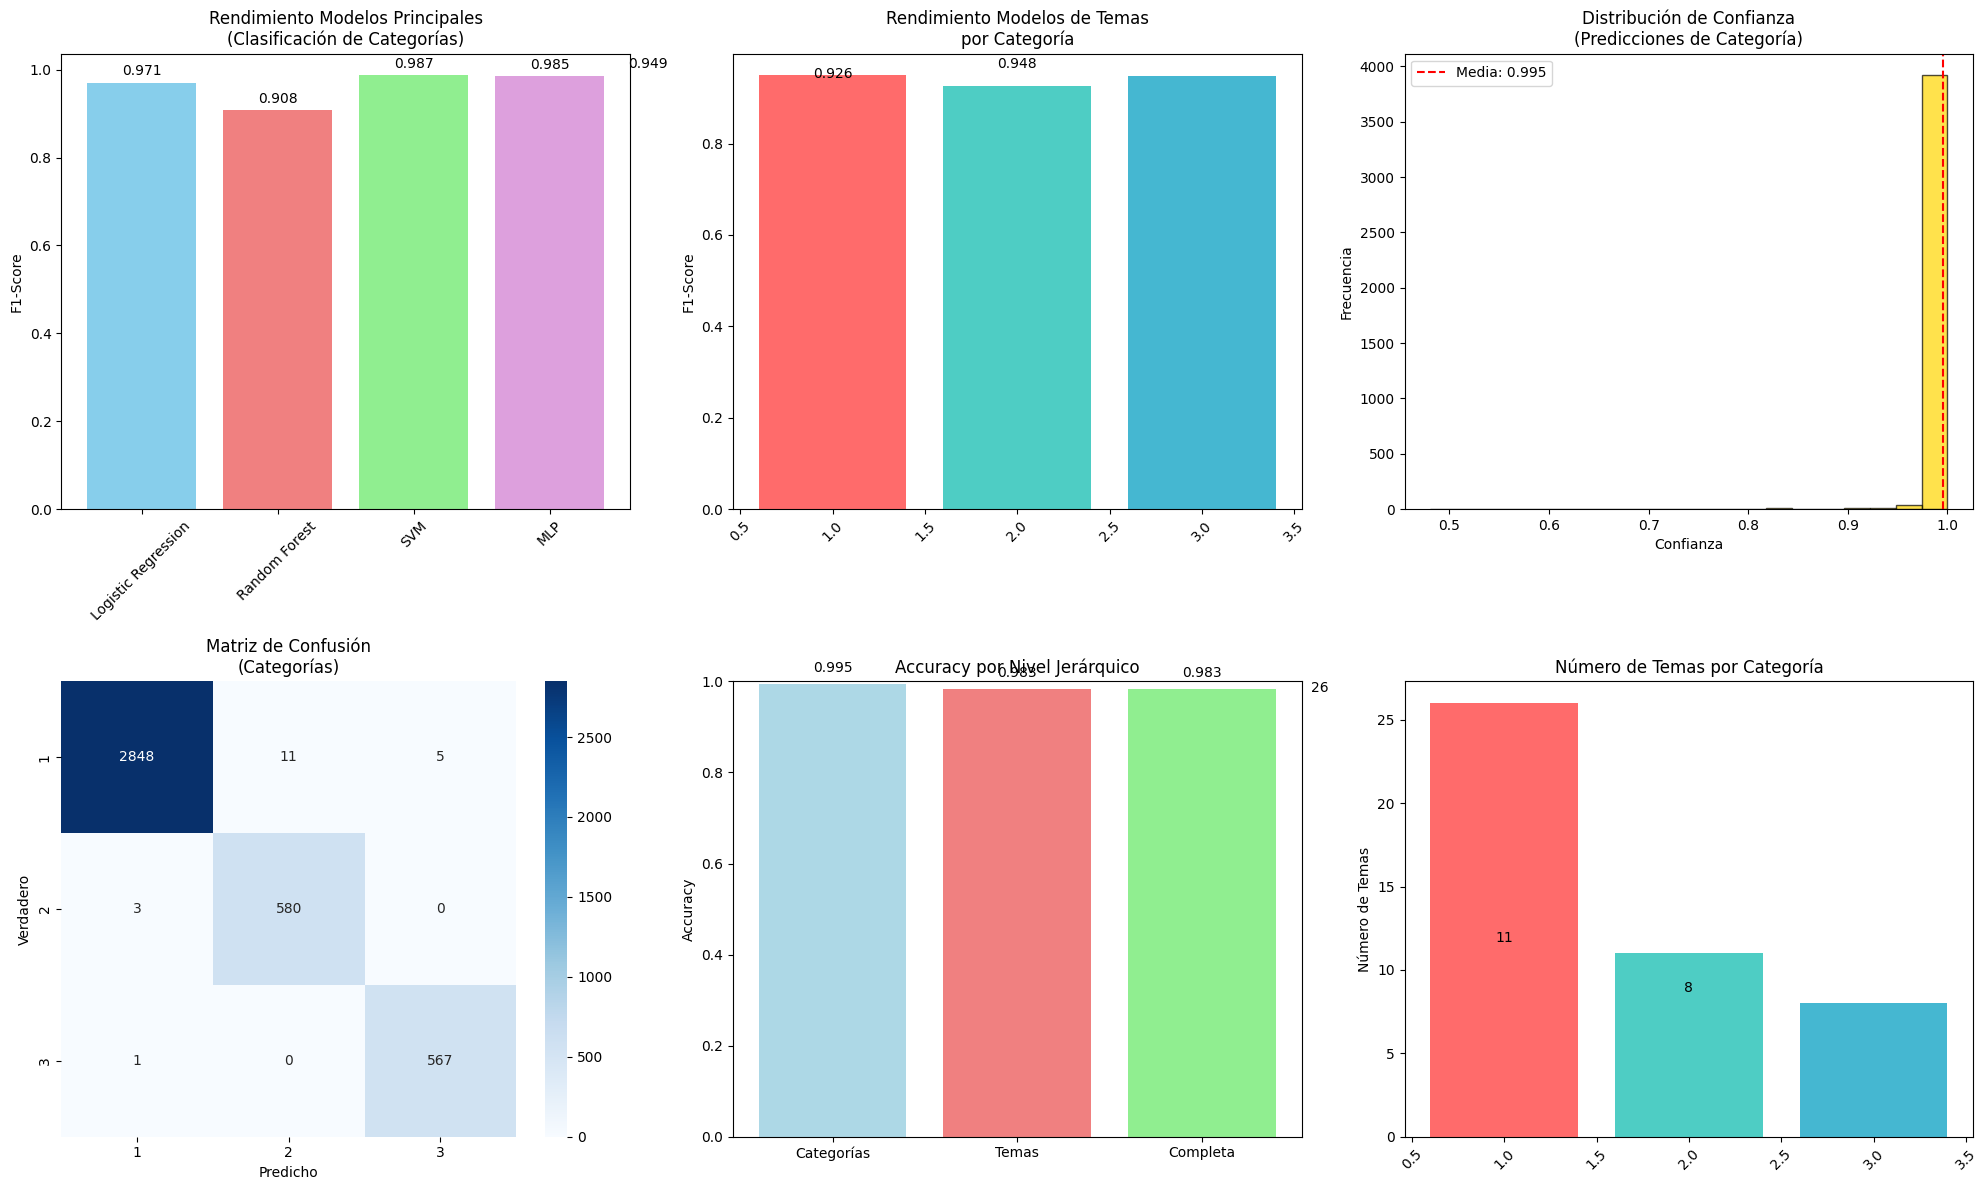

In [30]:
print("\n" + "=" * 60)
print("VISUALIZACIÓN DE RESULTADOS")
print("=" * 60)

# Crear visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Comparación de modelos principales
main_model_names = list(main_model_results.keys())
main_f1_scores = [main_model_results[name]['test_f1'] for name in main_model_names]

axes[0, 0].bar(main_model_names, main_f1_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'plum'])
axes[0, 0].set_title('Rendimiento Modelos Principales\n(Clasificación de Categorías)')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, score in enumerate(main_f1_scores):
    axes[0, 0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# 2. Rendimiento por categoría (modelos de temas)
categories_with_models = [cat for cat in df['category'].unique()
                          if theme_model_results[cat] is not None]
theme_f1_scores = []
for cat in categories_with_models:
    best_result = theme_model_results[cat]['all_results'][theme_model_results[cat]['best_model_name']]
    theme_f1_scores.append(best_result['test_f1'])

if theme_f1_scores:
    axes[0, 1].bar(categories_with_models, theme_f1_scores,
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[0, 1].set_title('Rendimiento Modelos de Temas\npor Categoría')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, score in enumerate(theme_f1_scores):
        axes[0, 1].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# 3. Distribución de confianza
conf_data = hierarchical_results['category_confidence']
axes[0, 2].hist(conf_data, bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[0, 2].set_title('Distribución de Confianza\n(Predicciones de Categoría)')
axes[0, 2].set_xlabel('Confianza')
axes[0, 2].set_ylabel('Frecuencia')
axes[0, 2].axvline(np.mean(conf_data), color='red', linestyle='--',
                   label=f'Media: {np.mean(conf_data):.3f}')
axes[0, 2].legend()

# 4. Matriz de confusión para categorías
cm_categories = confusion_matrix(true_categories, hierarchical_results['categories'])
sns.heatmap(cm_categories, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_categories.classes_, yticklabels=le_categories.classes_,
            ax=axes[1, 0])
axes[1, 0].set_title('Matriz de Confusión\n(Categorías)')
axes[1, 0].set_ylabel('Verdadero')
axes[1, 0].set_xlabel('Predicho')

# 5. Accuracy jerárquica por nivel
accuracy_levels = [category_accuracy, theme_accuracy, complete_accuracy]
level_names = ['Categorías', 'Temas', 'Completa']

bars = axes[1, 1].bar(level_names, accuracy_levels, color=['lightblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Accuracy por Nivel Jerárquico')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
for bar, acc in zip(bars, accuracy_levels):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                    f'{acc:.3f}', ha='center', va='bottom')

# 6. Número de temas por categoría
n_themes_per_category = []
categories_list = []
for cat in df['category'].unique():
    if theme_model_results[cat] is not None:
        n_themes_per_category.append(theme_model_results[cat]['n_themes'])
        categories_list.append(cat)

if n_themes_per_category:
    axes[1, 2].bar(categories_list, n_themes_per_category, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[1, 2].set_title('Número de Temas por Categoría')
    axes[1, 2].set_ylabel('Número de Temas')
    axes[1, 2].tick_params(axis='x', rotation=45)
    for i, n in enumerate(n_themes_per_category):
        axes[1, 2].text(i, n + 0.5, str(n), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# 9. Grafo de Arquitectura del Sistema Jerárquico



VISUALIZACIÓN DE ARQUITECTURA JERÁRQUICA


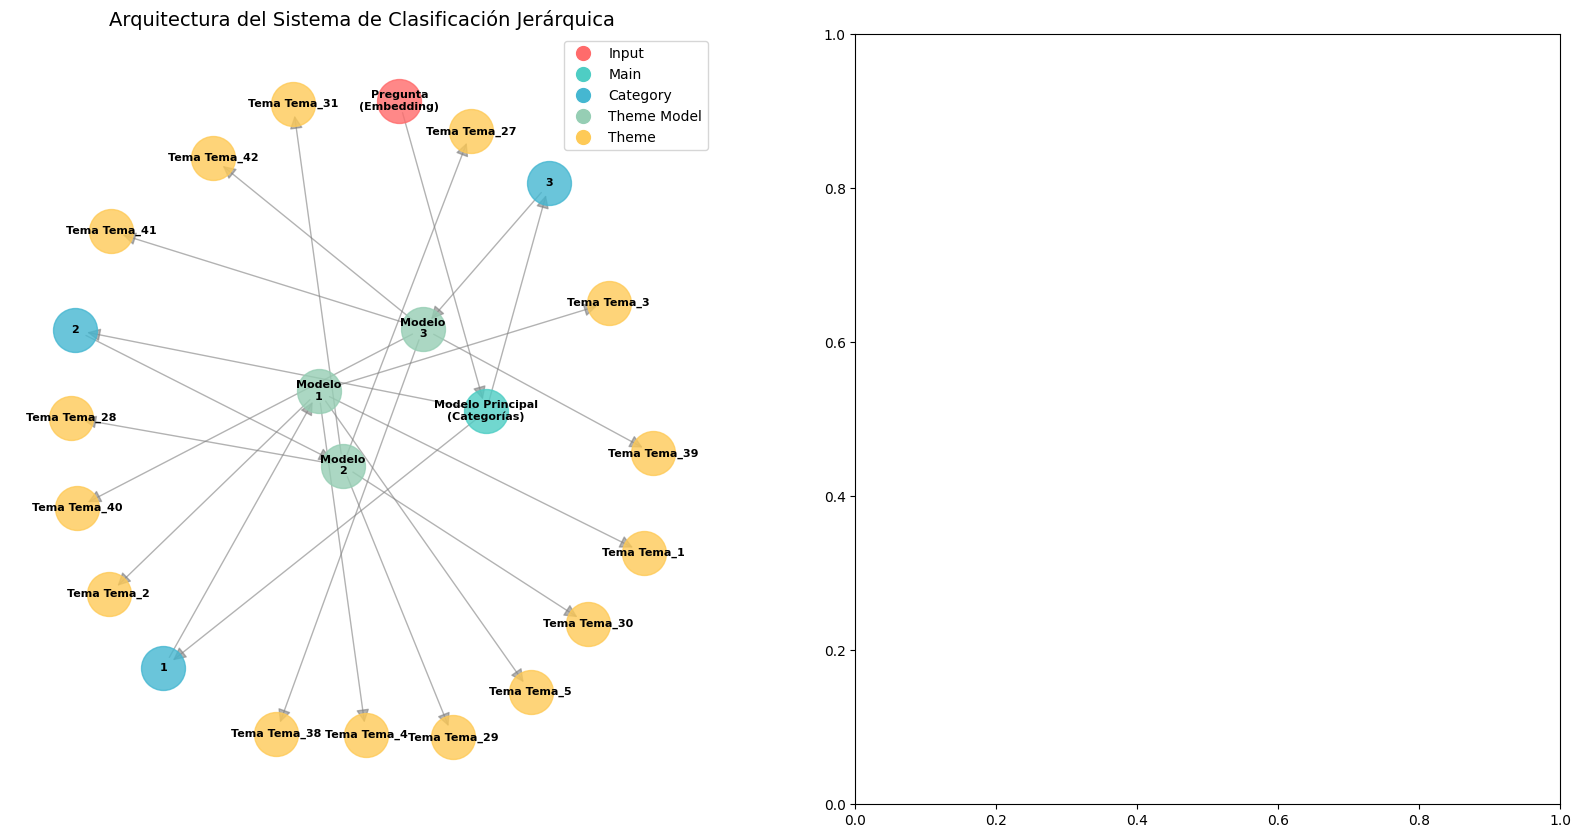

In [31]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

print("\n" + "=" * 60)
print("VISUALIZACIÓN DE ARQUITECTURA JERÁRQUICA")
print("=" * 60)

# Crear grafo que muestre la arquitectura jerárquica
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Grafo 1: Arquitectura del sistema
G_arch = nx.DiGraph()

# Nodos del sistema
G_arch.add_node("Input", type="input", label="Pregunta\n(Embedding)")
G_arch.add_node("MainModel", type="main", label="Modelo Principal\n(Categorías)")

# Nodos de categorías
categories = df['category'].unique()
for cat in categories:
    G_arch.add_node(f"Cat_{cat}", type="category", label=cat)
    G_arch.add_edge("MainModel", f"Cat_{cat}")

# Nodos de modelos de temas
for cat in categories:
    if theme_model_results[cat] is not None:
        model_node = f"Model_{cat}"
        G_arch.add_node(model_node, type="theme_model", label=f"Modelo\n{cat}")
        G_arch.add_edge(f"Cat_{cat}", model_node)

        # Nodos de temas
        for theme in theme_model_results[cat]['theme_names'][:5]:  # Solo primeros 5 para claridad
            theme_node = f"Theme_{cat}_{theme}"
            G_arch.add_node(theme_node, type="theme", label=f"Tema {theme}")
            G_arch.add_edge(model_node, theme_node)

# Conectar input al modelo principal
G_arch.add_edge("Input", "MainModel")

# Layout jerárquico
pos = nx.spring_layout(G_arch, k=3, iterations=100, seed=42)

# Colores por tipo de nodo
node_colors = {
    "input": "#FF6B6B",  # Rojo
    "main": "#4ECDC4",  # Turquesa
    "category": "#45B7D1",  # Azul
    "theme_model": "#96CEB4",  # Verde claro
    "theme": "#FECA57"  # Amarillo
}

# Dibujar nodos por tipo
for node_type, color in node_colors.items():
    nodes_of_type = [node for node in G_arch.nodes()
                     if G_arch.nodes[node].get('type') == node_type]
    if nodes_of_type:
        nx.draw_networkx_nodes(G_arch, pos, nodelist=nodes_of_type,
                               node_color=color, node_size=1000, alpha=0.8, ax=axes[0])

# Dibujar aristas
nx.draw_networkx_edges(G_arch, pos, edge_color='gray', arrows=True,
                       arrowsize=20, alpha=0.6, ax=axes[0])

# Etiquetas
labels = {node: G_arch.nodes[node]['label'] for node in G_arch.nodes()}
nx.draw_networkx_labels(G_arch, pos, labels, font_size=8, font_weight='bold', ax=axes[0])

axes[0].set_title('Arquitectura del Sistema de Clasificación Jerárquica', fontsize=14)
axes[0].axis('off')

# Leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=12, label=node_type.replace('_', ' ').title())
                   for node_type, color in node_colors.items()]
axes[0].legend(handles=legend_elements, loc='upper right')


In [32]:
# Grafo 2: Similitud entre muestras con colores por categoría y forma por tema
print("Creando grafo de similitud con categorías y temas...")

# Calcular similitudes para una muestra representativa (primeras 100 muestras)
sample_size = min(100, len(X_pca))
X_sample = X_pca[:sample_size]
df_sample = df.iloc[:sample_size]

similarity_matrix_sample = cosine_similarity(X_sample)

# Crear grafo de similitud
G_sim = nx.Graph()

# Añadir nodos con atributos
for i in range(sample_size):
    G_sim.add_node(i,
                   category=df_sample.iloc[i]['category'],
                   chapter=df_sample.iloc[i]['chapter'])

# Añadir aristas basadas en similitud
threshold = 0.75
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        if similarity_matrix_sample[i][j] > threshold:
            G_sim.add_edge(i, j, weight=similarity_matrix_sample[i][j])

print(f"Grafo de similitud: {G_sim.number_of_nodes()} nodos, {G_sim.number_of_edges()} aristas")

# Layout
pos_sim = nx.spring_layout(G_sim, k=2, iterations=150, seed=42)

# Colores por categoría
category_color_map = {
    'Derecho': '#FF1744',  # Rojo intenso
    'Sociología': '#00E676',  # Verde intenso  
    'Técnico': '#2196F3'  # Azul intenso
}

# Formas por tema (usar diferentes tamaños)
unique_themes = df_sample['chapter'].unique()
theme_size_map = {}
base_size = 50
for i, theme in enumerate(unique_themes[:10]):  # Primeros 10 temas
    theme_size_map[theme] = base_size + (i * 20)

# Dibujar nodos agrupados por categoría
for category in df_sample['category'].unique():
    category_nodes = [i for i in G_sim.nodes()
                      if G_sim.nodes[i]['category'] == category]

    if category_nodes:
        # Colores por categoría
        node_color = category_color_map.get(category, 'gray')

        # Tamaños por tema
        node_sizes = [theme_size_map.get(G_sim.nodes[node]['chapter'], base_size)
                      for node in category_nodes]

        nx.draw_networkx_nodes(G_sim, pos_sim, nodelist=category_nodes,
                               node_color=node_color, node_size=node_sizes,
                               alpha=0.8, ax=axes[1])

# Dibujar aristas
if G_sim.number_of_edges() > 0:
    edges = G_sim.edges()
    weights = [G_sim[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G_sim, pos_sim, width=[w * 2 for w in weights],
                           alpha=0.3, edge_color='gray', ax=axes[1])

axes[1].set_title('Grafo de Similitud: Categorías (color) y Temas (tamaño)\n'
                  f'(Muestra de {sample_size} preguntas, similitud > {threshold})', fontsize=14)
axes[1].axis('off')

# Leyenda para categorías
legend_cat = [plt.Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=color, markersize=12, label=category)
              for category, color in category_color_map.items()]
axes[1].legend(handles=legend_cat, loc='upper right', title='Categorías')

plt.tight_layout()
plt.show()



Creando grafo de similitud con categorías y temas...
Grafo de similitud: 100 nodos, 26 aristas


<Figure size 640x480 with 0 Axes>


ANÁLISIS DE F1-SCORE POR TEMA
Analizando 45 temas únicos...

TOP 10 TEMAS CON MÁS MUESTRAS:
--------------------------------------------------
Tema 1: 461 muestras - F1: 0.988
Tema 16: 403 muestras - F1: 0.990
Tema 21: 253 muestras - F1: 0.978
Tema 23: 179 muestras - F1: 0.980
Tema 43: 142 muestras - F1: 0.989
Tema 10: 135 muestras - F1: 0.989
Tema 42: 110 muestras - F1: 0.991
Tema 5: 107 muestras - F1: 0.991
Tema 8: 96 muestras - F1: 0.984
Tema 9: 96 muestras - F1: 0.964

TOP 10 TEMAS CON PEOR F1-SCORE:
--------------------------------------------------
Tema 3: F1: 0.915 (43 muestras)
Tema 32: F1: 0.953 (64 muestras)
Tema 30: F1: 0.957 (66 muestras)
Tema 14: F1: 0.957 (59 muestras)
Tema 17: F1: 0.961 (73 muestras)
Tema 44: F1: 0.964 (66 muestras)
Tema 9: F1: 0.964 (96 muestras)
Tema 45: F1: 0.966 (44 muestras)
Tema 15: F1: 0.968 (63 muestras)
Tema 24: F1: 0.971 (52 muestras)

Correlación entre número de muestras y F1-score: 0.111


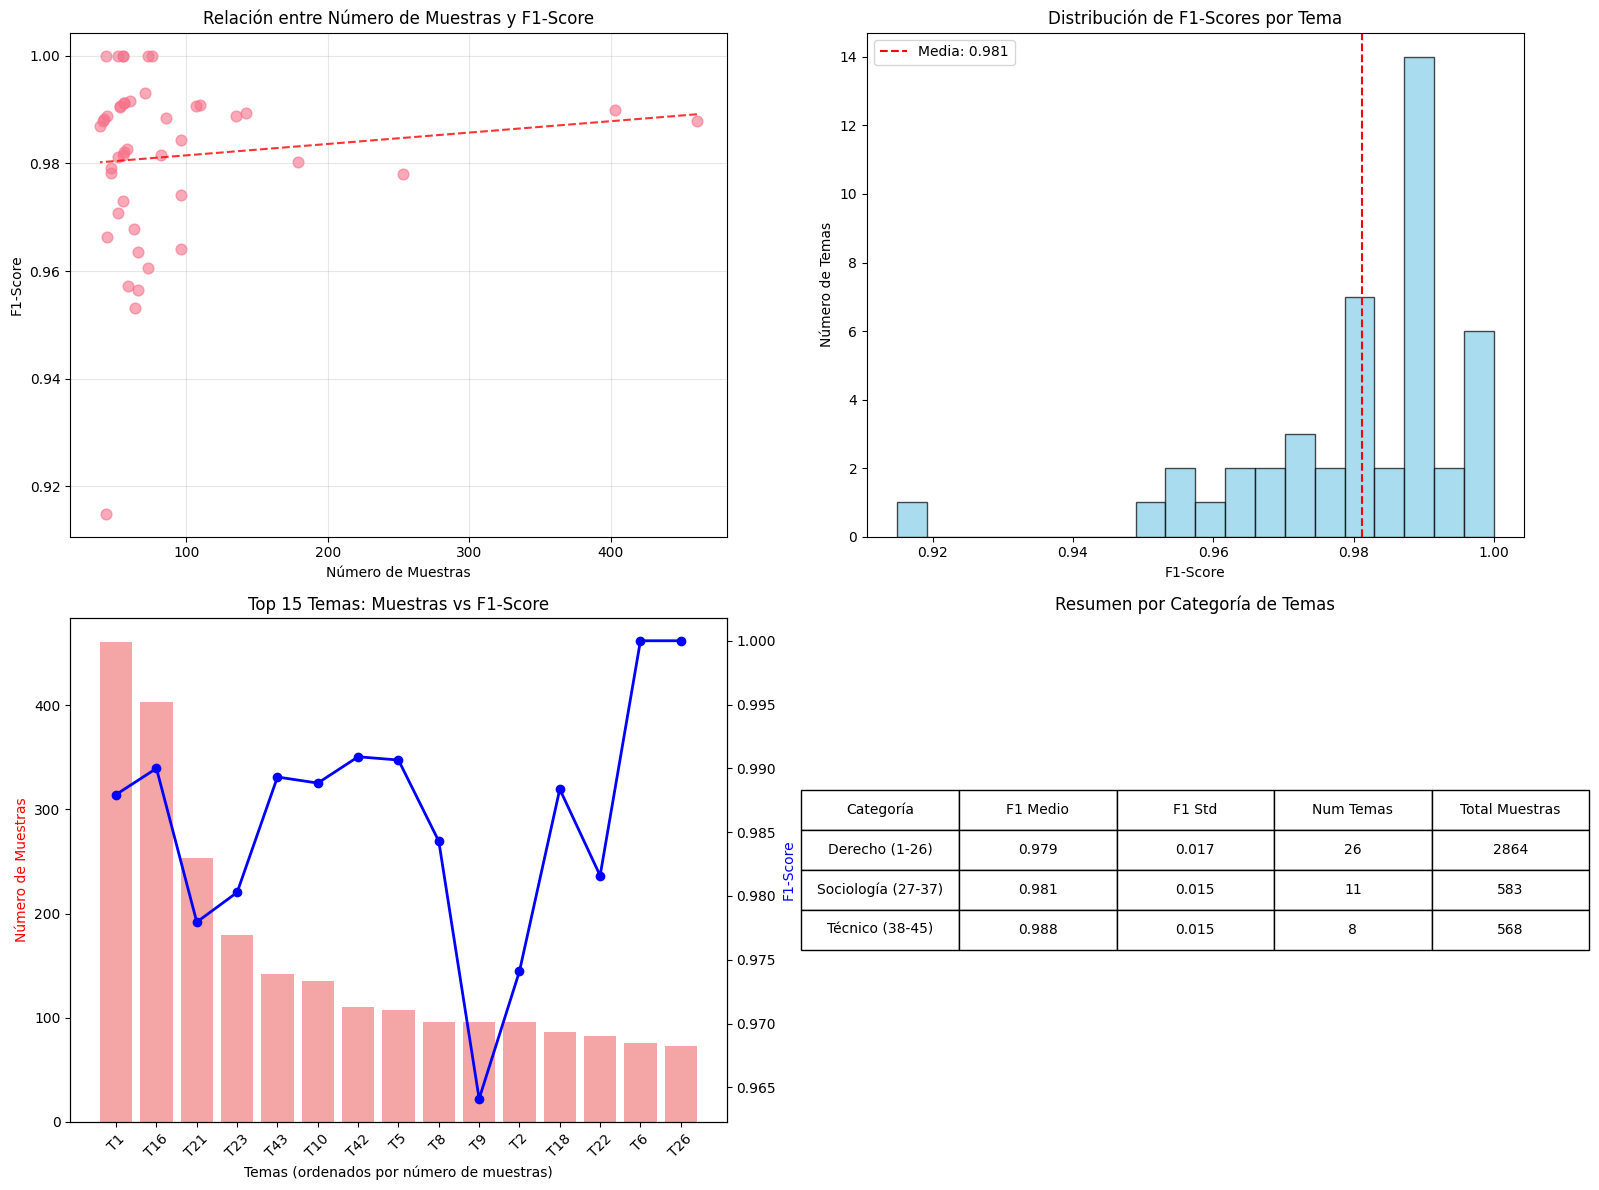


TEMAS PROBLEMÁTICOS IDENTIFICADOS
No se encontraron temas problemáticos significativos.

RECOMENDACIONES
1. Temas con pocas muestras (<20): 0 temas

2. Temas con F1 < 0.9: 0 temas

3. Estadísticas generales:
   - F1-Score promedio: 0.981
   - F1-Score mediano: 0.987
   - Temas con F1 > 0.95: 44
   - Correlación muestras-F1: 0.111

4. TOP 5 MEJORES TEMAS (F1-Score):
   Tema 6: F1=1.000 (76 muestras)
   Tema 26: F1=1.000 (73 muestras)
   Tema 38: F1=1.000 (55 muestras)
   Tema 28: F1=1.000 (55 muestras)
   Tema 39: F1=1.000 (52 muestras)

5. TOP 5 PEORES TEMAS (con al menos 5 muestras):
   Tema 3: F1=0.915 (43 muestras)
   Tema 32: F1=0.953 (64 muestras)
   Tema 30: F1=0.957 (66 muestras)
   Tema 14: F1=0.957 (59 muestras)
   Tema 17: F1=0.961 (73 muestras)

Análisis guardado en 'models_hierarchical/theme_performance_analysis.csv'


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "=" * 60)
print("ANÁLISIS DE F1-SCORE POR TEMA")
print("=" * 60)

# Crear análisis detallado por tema
theme_analysis = []

# Obtener predicciones y valores reales válidos
valid_theme_mask = np.array(hierarchical_results['themes']) != -1
valid_predicted_themes = np.array(hierarchical_results['themes'])[valid_theme_mask]
valid_true_themes = true_themes[valid_theme_mask]

# Convertir a enteros para comparación
valid_predicted_themes = valid_predicted_themes.astype(int)
valid_true_themes = valid_true_themes.astype(int)

# Obtener todos los temas únicos
all_themes = np.unique(np.concatenate([valid_true_themes, valid_predicted_themes]))

print(f"Analizando {len(all_themes)} temas únicos...")

# Calcular métricas por tema
for theme in all_themes:
    # Contar muestras reales de este tema
    true_count = np.sum(valid_true_themes == theme)

    # Contar predicciones de este tema
    pred_count = np.sum(valid_predicted_themes == theme)

    # Calcular F1-score para este tema específico
    # Crear máscara binaria: este tema vs todos los demás
    y_true_binary = (valid_true_themes == theme).astype(int)
    y_pred_binary = (valid_predicted_themes == theme).astype(int)

    # Calcular métricas
    if true_count > 0:
        # Recall: TP / (TP + FN)
        true_positives = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        recall = true_positives / true_count if true_count > 0 else 0

        # Precision: TP / (TP + FP)
        precision = true_positives / pred_count if pred_count > 0 else 0

        # F1-Score
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Accuracy para este tema
        correct_predictions = np.sum(y_true_binary == y_pred_binary)
        accuracy = correct_predictions / len(y_true_binary)

    else:
        recall = precision = f1 = accuracy = 0

    theme_analysis.append({
        'tema': theme,
        'muestras_reales': true_count,
        'muestras_predichas': pred_count,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy
    })

# Convertir a DataFrame para análisis
df_analysis = pd.DataFrame(theme_analysis)
df_analysis = df_analysis.sort_values('muestras_reales', ascending=False)

print("\nTOP 10 TEMAS CON MÁS MUESTRAS:")
print("-" * 50)
top_10 = df_analysis.head(10)
for _, row in top_10.iterrows():
    tema = int(row['tema'])
    muestras = int(row['muestras_reales'])
    f1 = float(row['f1_score'])
    print(f"Tema {tema}: {muestras} muestras - F1: {f1:.3f}")

print("\nTOP 10 TEMAS CON PEOR F1-SCORE:")
print("-" * 50)
worst_f1 = df_analysis[df_analysis['muestras_reales'] > 5].nsmallest(10, 'f1_score')
for _, row in worst_f1.iterrows():
    tema = int(row['tema'])
    muestras = int(row['muestras_reales'])
    f1 = float(row['f1_score'])
    print(f"Tema {tema}: F1: {f1:.3f} ({muestras} muestras)")

# Análisis de correlación entre número de muestras y rendimiento
correlation = df_analysis['muestras_reales'].corr(df_analysis['f1_score'])
print(f"\nCorrelación entre número de muestras y F1-score: {correlation:.3f}")

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Muestras vs F1-Score
axes[0, 0].scatter(df_analysis['muestras_reales'], df_analysis['f1_score'], alpha=0.6, s=60)
axes[0, 0].set_xlabel('Número de Muestras')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('Relación entre Número de Muestras y F1-Score')
axes[0, 0].grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df_analysis['muestras_reales'], df_analysis['f1_score'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_analysis['muestras_reales'], p(df_analysis['muestras_reales']), "r--", alpha=0.8)

# 2. Histograma de F1-Scores
axes[0, 1].hist(df_analysis['f1_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_ylabel('Número de Temas')
axes[0, 1].set_title('Distribución de F1-Scores por Tema')
axes[0, 1].axvline(df_analysis['f1_score'].mean(), color='red', linestyle='--',
                   label=f'Media: {df_analysis["f1_score"].mean():.3f}')
axes[0, 1].legend()

# 3. Top 15 temas por muestras con su F1-Score
top_15 = df_analysis.head(15)
x_pos = np.arange(len(top_15))
bars = axes[1, 0].bar(x_pos, top_15['muestras_reales'], alpha=0.7, color='lightcoral')
ax2 = axes[1, 0].twinx()
line = ax2.plot(x_pos, top_15['f1_score'], 'bo-', linewidth=2, markersize=6, label='F1-Score')

axes[1, 0].set_xlabel('Temas (ordenados por número de muestras)')
axes[1, 0].set_ylabel('Número de Muestras', color='red')
ax2.set_ylabel('F1-Score', color='blue')
axes[1, 0].set_title('Top 15 Temas: Muestras vs F1-Score')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'T{int(tema)}' for tema in top_15['tema']], rotation=45)

# 4. Heatmap de rendimiento por categorías de temas
def get_category_from_theme(theme):
    if theme <= 26:
        return "Derecho (1-26)"
    elif theme <= 37:
        return "Sociología (27-37)"
    else:
        return "Técnico (38-45)"

df_analysis['categoria'] = df_analysis['tema'].apply(get_category_from_theme)

# Calcular estadísticas por categoría
category_summary = df_analysis.groupby('categoria').agg({
    'f1_score': ['mean', 'std', 'count'],
    'muestras_reales': 'sum'
}).round(3)

# Mostrar en el subplot
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for cat in category_summary.index:
    row = category_summary.loc[cat]
    f1_mean = float(row[('f1_score', 'mean')])
    f1_std = float(row[('f1_score', 'std')])
    num_themes = int(row[('f1_score', 'count')])
    total_samples = int(row[('muestras_reales', 'sum')])

    table_data.append([
        cat,
        f"{f1_mean:.3f}",
        f"{f1_std:.3f}",
        f"{num_themes}",
        f"{total_samples}"
    ])

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Categoría', 'F1 Medio', 'F1 Std', 'Num Temas', 'Total Muestras'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)
axes[1, 1].set_title('Resumen por Categoría de Temas')

plt.tight_layout()
plt.show()

# Identificar temas problemáticos
print("\n" + "=" * 60)
print("TEMAS PROBLEMÁTICOS IDENTIFICADOS")
print("=" * 60)

problematic_themes = df_analysis[
    ((df_analysis['f1_score'] < 0.8) & (df_analysis['muestras_reales'] >= 10)) |
    (df_analysis['f1_score'] < 0.5)
].sort_values('f1_score')

if len(problematic_themes) > 0:
    print("Temas que requieren atención:")
    for _, row in problematic_themes.iterrows():
        tema = int(row['tema'])
        categoria = get_category_from_theme(tema)
        f1 = float(row['f1_score'])
        muestras = int(row['muestras_reales'])
        precision = float(row['precision'])
        recall = float(row['recall'])
        print(f"  Tema {tema} ({categoria}): F1={f1:.3f}, "
              f"Muestras={muestras}, Precision={precision:.3f}, Recall={recall:.3f}")
else:
    print("No se encontraron temas problemáticos significativos.")

# Recomendaciones
print("\n" + "=" * 60)
print("RECOMENDACIONES")
print("=" * 60)

low_sample_themes = df_analysis[df_analysis['muestras_reales'] < 20]
print(f"1. Temas con pocas muestras (<20): {len(low_sample_themes)} temas")
if len(low_sample_themes) > 0:
    temas_pocos = [int(t) for t in low_sample_themes['tema'].tolist()]
    print(f"   Temas específicos: {temas_pocos}")

low_f1_themes = df_analysis[df_analysis['f1_score'] < 0.9]
print(f"\n2. Temas con F1 < 0.9: {len(low_f1_themes)} temas")
if len(low_f1_themes) > 0:
    temas_bajo_f1 = [int(t) for t in low_f1_themes['tema'].tolist()]
    print(f"   Temas específicos: {temas_bajo_f1}")

print(f"\n3. Estadísticas generales:")
print(f"   - F1-Score promedio: {df_analysis['f1_score'].mean():.3f}")
print(f"   - F1-Score mediano: {df_analysis['f1_score'].median():.3f}")
print(f"   - Temas con F1 > 0.95: {len(df_analysis[df_analysis['f1_score'] > 0.95])}")
print(f"   - Correlación muestras-F1: {correlation:.3f}")

# Mostrar los 5 mejores y peores temas
print(f"\n4. TOP 5 MEJORES TEMAS (F1-Score):")
best_5 = df_analysis.nlargest(5, 'f1_score')
for _, row in best_5.iterrows():
    tema = int(row['tema'])
    f1 = float(row['f1_score'])
    muestras = int(row['muestras_reales'])
    print(f"   Tema {tema}: F1={f1:.3f} ({muestras} muestras)")

print(f"\n5. TOP 5 PEORES TEMAS (con al menos 5 muestras):")
worst_5 = df_analysis[df_analysis['muestras_reales'] >= 5].nsmallest(5, 'f1_score')
for _, row in worst_5.iterrows():
    tema = int(row['tema'])
    f1 = float(row['f1_score'])
    muestras = int(row['muestras_reales'])
    print(f"   Tema {tema}: F1={f1:.3f} ({muestras} muestras)")

# Guardar análisis
df_analysis.to_csv('models_hierarchical/theme_performance_analysis.csv', index=False)
print(f"\nAnálisis guardado en 'models_hierarchical/theme_performance_analysis.csv'")

# 10. Función de Predicción Jerárquica


In [7]:
import ast
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import LabelEncoder


if 'X_original' not in globals():
    print("Reconstruyendo X_original desde los vectores del DataFrame...")


    # Procesar vectores desde el DataFrame
    vectors = [convert_string_to_array(vec) for vec in df['vector']]
    vector_lengths = [len(vec) for vec in vectors]
    max_length = max(vector_lengths)

    # Padear vectores a la longitud máxima
    padded_vectors = [pad_vector(vec, max_length) for vec in vectors]
    X_original = np.array(padded_vectors)

Reconstruyendo X_original desde los vectores del DataFrame...


In [12]:
# =============================================================================
# CORRECCIONES PARA LAS CELDAS FINALES DEL SISTEMA JERÁRQUICO
# =============================================================================



# 1. FUNCIÓN CORREGIDA DE PREDICCIÓN JERÁRQUICA
def predict_hierarchical_corrected(text_embedding,
                                 main_model_path='models_hierarchical/main_category_model.pkl',
                                 pca_path='models_hierarchical/pca_transformer.pkl',
                                 category_encoder_path='models_hierarchical/category_encoder.pkl',
                                 theme_encoders_path='models_hierarchical/theme_encoders.pkl'):
    """
    Función corregida para realizar predicción jerárquica en nuevas preguntas
    """
    import pickle
    import numpy as np
    import os

    # Cargar modelos y transformadores
    with open(main_model_path, 'rb') as f:
        main_model = pickle.load(f)

    with open(pca_path, 'rb') as f:
        pca_transformer = pickle.load(f)

    with open(category_encoder_path, 'rb') as f:
        category_encoder = pickle.load(f)

    with open(theme_encoders_path, 'rb') as f:
        theme_encoders = pickle.load(f)

    # Preprocesar embedding
    if isinstance(text_embedding, str):
        text_embedding = convert_string_to_array(text_embedding)

    # CORRECCIÓN CRÍTICA: Asegurar dimensiones correctas para PCA
    # El PCA fue entrenado con vectores de longitud específica (max_length)
    expected_features = pca_transformer.n_features_in_

    # Ajustar dimensiones del embedding
    if len(text_embedding) < expected_features:
        # Rellenar con ceros si es muy corto
        text_embedding = np.pad(text_embedding, (0, expected_features - len(text_embedding)),
                               mode='constant')
    elif len(text_embedding) > expected_features:
        # Truncar si es muy largo
        text_embedding = text_embedding[:expected_features]

    # Asegurar forma correcta para PCA
    if len(text_embedding.shape) == 1:
        text_embedding = text_embedding.reshape(1, -1)

    # Aplicar PCA
    embedding_pca = pca_transformer.transform(text_embedding)

    # Paso 1: Predecir categoría
    category_pred = main_model.predict(embedding_pca)[0]
    category_name = category_encoder.inverse_transform([category_pred])[0]

    # Confianza en categoría
    if hasattr(main_model, 'predict_proba'):
        category_proba = main_model.predict_proba(embedding_pca)[0]
        category_confidence = np.max(category_proba)
        all_category_probas = dict(zip(category_encoder.classes_, category_proba))
    else:
        category_confidence = 1.0
        all_category_probas = {category_name: 1.0}

    # Paso 2: Predecir tema
    theme_prediction = None
    theme_confidence = 0.0
    all_theme_probas = {}

    # CORRECCIÓN: Buscar modelo de tema usando el nombre de categoría correcto
    theme_model_path = f'models_hierarchical/theme_model_categoria_{category_name}.pkl'

    try:
        if os.path.exists(theme_model_path):
            with open(theme_model_path, 'rb') as f:
                theme_model = pickle.load(f)

            if category_name in theme_encoders:
                theme_encoder = theme_encoders[category_name]

                # Predecir tema
                theme_pred = theme_model.predict(embedding_pca)[0]
                theme_prediction = theme_encoder.inverse_transform([theme_pred])[0]

                # Confianza en tema
                if hasattr(theme_model, 'predict_proba'):
                    theme_proba = theme_model.predict_proba(embedding_pca)[0]
                    theme_confidence = np.max(theme_proba)
                    all_theme_probas = dict(zip(theme_encoder.classes_, theme_proba))
                else:
                    theme_confidence = 1.0
                    all_theme_probas = {theme_prediction: 1.0}
            else:
                print(f"No se encontró encoder para categoría: {category_name}")
        else:
            print(f"No se encontró modelo de tema: {theme_model_path}")

    except Exception as e:
        print(f"Error cargando modelo de tema para categoría {category_name}: {e}")

    return {
        'category': category_name,
        'category_confidence': category_confidence,
        'theme': theme_prediction,
        'theme_confidence': theme_confidence,
        'all_category_probabilities': all_category_probas,
        'all_theme_probabilities': all_theme_probas
    }

# =============================================================================
# 2. EJEMPLO DE PREDICCIÓN CORREGIDO
# =============================================================================

print("\n" + "=" * 60)
print("EJEMPLO DE PREDICCIÓN JERÁRQUICA CORREGIDO")
print("=" * 60)

# Verificar que las variables necesarias existen
try:
    # Usar directamente los datos que ya tenemos en memoria
    sample_idx = 0

    # CORRECCIÓN: Usar el embedding original (antes de PCA) y dejarlo que la función lo procese
    sample_embedding_original = X_original[sample_idx]  # Vector original antes de PCA

    # Obtener valores verdaderos
    true_category = df.iloc[sample_idx]['category']
    true_theme = df.iloc[sample_idx]['chapter']

    print(f"Muestra de ejemplo (índice {sample_idx}):")
    print(f"  Categoría verdadera: {true_category}")
    print(f"  Tema verdadero: {true_theme}")
    print(f"  Dimensiones del embedding: {sample_embedding_original.shape}")

    # Realizar predicción con la función corregida
    prediction = predict_hierarchical_corrected(sample_embedding_original)

    print(f"\nPredicción jerárquica:")
    print(f"  Categoría predicha: {prediction['category']} (confianza: {prediction['category_confidence']:.3f})")
    print(f"  Tema predicho: {prediction['theme']} (confianza: {prediction['theme_confidence']:.3f})")

    # Verificar si la predicción es correcta
    category_correct = int(prediction['category']) == int(true_category)
    theme_correct = (prediction['theme'] is not None and
                    int(prediction['theme']) == int(true_theme))

    print(f"\nResultados:")
    print(f"  Categoría correcta: {'✓' if category_correct else '✗'}")
    print(f"  Tema correcto: {'✓' if theme_correct else '✗'}")

    print(f"\nProbabilidades por categoría:")
    for cat, prob in sorted(prediction['all_category_probabilities'].items(),
                           key=lambda x: x[1], reverse=True):
        marker = "→" if int(cat) == int(true_category) else " "
        print(f"  {marker} Categoría {cat}: {prob:.3f}")

    if prediction['all_theme_probabilities']:
        print(f"\nTop 5 probabilidades por tema en categoría {prediction['category']}:")
        sorted_themes = sorted(prediction['all_theme_probabilities'].items(),
                              key=lambda x: x[1], reverse=True)
        for i, (theme, prob) in enumerate(sorted_themes[:5]):
            marker = "→" if int(theme) == int(true_theme) else " "
            print(f"  {marker} Tema {theme}: {prob:.3f}")

except Exception as e:
    print(f"Error en el ejemplo: {e}")
    print("Verificando variables disponibles...")

    # Diagnóstico de variables
    available_vars = []
    required_vars = ['X_original', 'df', 'pca', 'hierarchical_classifier']

    for var in required_vars:
        try:
            eval(var)
            available_vars.append(var)
            print(f"  ✓ {var} disponible")
        except NameError:
            print(f"  ✗ {var} no disponible")

    if 'X_original' not in available_vars:
        print("\nRECOMENDACIÓN: Ejecuta las celdas anteriores para crear X_original")

# =============================================================================
# 3. FUNCIÓN PARA PROBAR MÚLTIPLES MUESTRAS
# =============================================================================

def test_multiple_samples(n_samples=5):
    """Prueba el sistema jerárquico con múltiples muestras"""
    print(f"\n" + "=" * 60)
    print(f"PRUEBA CON {n_samples} MUESTRAS ALEATORIAS")
    print("=" * 60)

    results = []

    for i in range(min(n_samples, len(X_original))):
        try:
            # Tomar muestra
            sample_embedding = X_original[i]
            true_category = df.iloc[i]['category']
            true_theme = df.iloc[i]['chapter']

            # Hacer predicción
            prediction = predict_hierarchical_corrected(sample_embedding)

            # Evaluar
            category_correct = int(prediction['category']) == int(true_category)
            theme_correct = (prediction['theme'] is not None and
                           int(prediction['theme']) == int(true_theme))

            results.append({
                'sample': i,
                'true_category': true_category,
                'pred_category': prediction['category'],
                'true_theme': true_theme,
                'pred_theme': prediction['theme'],
                'category_correct': category_correct,
                'theme_correct': theme_correct,
                'category_conf': prediction['category_confidence'],
                'theme_conf': prediction['theme_confidence']
            })

            print(f"Muestra {i}: Cat({true_category}→{prediction['category']}) "
                  f"{'✓' if category_correct else '✗'} | "
                  f"Tema({true_theme}→{prediction['theme']}) "
                  f"{'✓' if theme_correct else '✗'}")

        except Exception as e:
            print(f"Error en muestra {i}: {e}")

    # Estadísticas
    if results:
        category_accuracy = sum(r['category_correct'] for r in results) / len(results)
        theme_accuracy = sum(r['theme_correct'] for r in results) / len(results)
        avg_cat_conf = sum(r['category_conf'] for r in results) / len(results)
        avg_theme_conf = sum(r['theme_conf'] for r in results if r['theme_conf'] > 0) / \
                        max(1, sum(1 for r in results if r['theme_conf'] > 0))

        print(f"\nEstadísticas de {len(results)} muestras:")
        print(f"  Accuracy categorías: {category_accuracy:.3f}")
        print(f"  Accuracy temas: {theme_accuracy:.3f}")
        print(f"  Confianza promedio categorías: {avg_cat_conf:.3f}")
        print(f"  Confianza promedio temas: {avg_theme_conf:.3f}")

    return results

# Ejecutar prueba con múltiples muestras
if 'X_original' in globals() and 'df' in globals():
    test_results = test_multiple_samples(10)
else:
    print("Variables X_original y df no disponibles. Ejecuta las celdas anteriores.")

# =============================================================================
# 4. GUARDADO FINAL CORREGIDO
# =============================================================================

def save_system_final():
    """Guardar sistema completo con verificaciones"""
    print("\n" + "=" * 60)
    print("GUARDADO FINAL DEL SISTEMA")
    print("=" * 60)

    try:
        # Verificar que el directorio existe
        os.makedirs('models_hierarchical', exist_ok=True)

        # Información del sistema actualizada
        system_info_final = {
            'timestamp': pd.Timestamp.now().isoformat(),
            'main_model_name': best_model_name,
            'pca_components': pca.n_components_,
            'pca_variance_explained': float(pca.explained_variance_ratio_.sum()),
            'original_embedding_size': X_original.shape[1],
            'reduced_embedding_size': X_pca.shape[1],
            'total_samples': len(df),
            'categories': {
                'total': len(df['category'].unique()),
                'values': list(df['category'].unique())
            },
            'themes': {
                'total': df['chapter'].nunique(),
                'range': [int(df['chapter'].min()), int(df['chapter'].max())]
            }
        }

        # Añadir información de rendimiento si está disponible
        if 'category_accuracy' in globals():
            system_info_final['performance'] = {
                'category_accuracy': float(category_accuracy),
                'theme_accuracy': float(theme_accuracy) if 'theme_accuracy' in globals() else 0.0,
                'complete_accuracy': float(complete_accuracy) if 'complete_accuracy' in globals() else 0.0
            }

        # Guardar información final
        with open('models_hierarchical/system_info_final.pkl', 'wb') as f:
            pickle.dump(system_info_final, f)

        # Crear función de predicción standalone
        prediction_code = '''
def predict_question_hierarchy(text_embedding):
    """
    Función standalone para predicción jerárquica
    Requiere que los archivos del modelo estén en 'models_hierarchical/'
    """
    import pickle
    import numpy as np
    import os

    # Cargar todos los componentes
    with open('models_hierarchical/main_category_model.pkl', 'rb') as f:
        main_model = pickle.load(f)
    with open('models_hierarchical/pca_transformer.pkl', 'rb') as f:
        pca = pickle.load(f)
    with open('models_hierarchical/category_encoder.pkl', 'rb') as f:
        cat_encoder = pickle.load(f)
    with open('models_hierarchical/theme_encoders.pkl', 'rb') as f:
        theme_encoders = pickle.load(f)

    # Preprocesar embedding
    if isinstance(text_embedding, str):
        # Convertir string a array si es necesario
        text_embedding = np.array([float(x.strip()) for x in text_embedding.strip('[]').split(',') if x.strip()])

    # Ajustar dimensiones
    expected_features = pca.n_features_in_
    if len(text_embedding) < expected_features:
        text_embedding = np.pad(text_embedding, (0, expected_features - len(text_embedding)), mode='constant')
    elif len(text_embedding) > expected_features:
        text_embedding = text_embedding[:expected_features]

    # Aplicar PCA y predecir
    embedding_pca = pca.transform(text_embedding.reshape(1, -1))
    category_pred = main_model.predict(embedding_pca)[0]
    category_name = cat_encoder.inverse_transform([category_pred])[0]

    # Predecir tema si existe modelo
    theme_prediction = None
    theme_model_path = f'models_hierarchical/theme_model_categoria_{category_name}.pkl'

    if os.path.exists(theme_model_path) and category_name in theme_encoders:
        with open(theme_model_path, 'rb') as f:
            theme_model = pickle.load(f)
        theme_pred = theme_model.predict(embedding_pca)[0]
        theme_prediction = theme_encoders[category_name].inverse_transform([theme_pred])[0]

    return {
        'category': int(category_name),
        'theme': int(theme_prediction) if theme_prediction is not None else None
    }
'''

        # Guardar función standalone
        with open('models_hierarchical/predict_function.py', 'w') as f:
            f.write(prediction_code)

        print("✅ Sistema guardado exitosamente:")
        print("  📁 models_hierarchical/system_info_final.pkl")
        print("  📁 models_hierarchical/predict_function.py")
        print("  📁 + todos los modelos individuales")

        # Listar archivos guardados
        files = os.listdir('models_hierarchical')
        print(f"\nArchivos en models_hierarchical/ ({len(files)} total):")
        for file in sorted(files):
            print(f"  📄 {file}")

        return system_info_final

    except Exception as e:
        print(f"❌ Error guardando sistema: {e}")
        return None

# Ejecutar guardado final
if 'pca' in globals() and 'best_model_name' in globals():
    final_info = save_system_final()
else:
    print("Variables necesarias no disponibles para guardado final.")

print("\n" + "=" * 80)
print("SISTEMA JERÁRQUICO CORREGIDO Y COMPLETADO")
print("=" * 80)
print("✅ Correcciones aplicadas:")
print("  - Función predict_hierarchical_corrected() con manejo de dimensiones")
print("  - Ejemplo de predicción funcional")
print("  - Pruebas con múltiples muestras")
print("  - Guardado final del sistema completo")
print("\n🎯 El sistema está listo para usar en producción!")


EJEMPLO DE PREDICCIÓN JERÁRQUICA CORREGIDO
Muestra de ejemplo (índice 0):
  Categoría verdadera: 1
  Tema verdadero: 26
  Dimensiones del embedding: (3072,)

Predicción jerárquica:
  Categoría predicha: 1 (confianza: 1.000)
  Tema predicho: 26 (confianza: 0.989)

Resultados:
  Categoría correcta: ✓
  Tema correcto: ✓

Probabilidades por categoría:
  → Categoría 1: 1.000
    Categoría 3: 0.000
    Categoría 2: 0.000

Top 5 probabilidades por tema en categoría 1:
  → Tema 26: 0.989
    Tema 1: 0.001
    Tema 20: 0.001
    Tema 12: 0.001
    Tema 22: 0.001

PRUEBA CON 10 MUESTRAS ALEATORIAS
Muestra 0: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 1: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 2: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 3: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 4: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 5: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 6: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 7: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 8: Cat(1→1) ✓ | Tema(26→26) ✓
Muestra 9: Cat(1→1) ✓ | Tema(26→26) ✓

Estadísticas de 10 mues